# Empirical Study

## function & read data

In [ ]:
!pip install ruptures

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 9.8 MB/s eta 0:00:00


In [ ]:
!pip install gurobipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 40.1 MB/s eta 0:00:00


In [ ]:
import ruptures as rpt
import gurobipy as grb

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [ ]:
# Groubi set up
params = {
"WLSACCESSID": '39b37664-ac84-4511-9715-9ffea877c151',
"WLSSECRET": '97aeb2fe-29f9-4a0b-9012-816d173d3c59',
"LICENSEID": 945172,
}
env = grb.Env(params=params)

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 945172
Academic license - for non-commercial use only - registered to toza0004@student.monash.edu


In [ ]:
def function_proposed_method(Y, X, quadratic_penalty = False, squared_BigM = False, l2_reg = False):
    # Input:
    # Y: a vector for the objective variable
    # X: (# of samples * # of predictors) matrix for predictors. if you consider a regression model with constant, you should include it in X matrix.

    # Output:
    # z_hat: location of the detected change points
    # opt_gap: gap of optimality
    # beta_hat: estimated coefficients


    p = X.shape[1]
    n = len(Y)
    #lam = 0.1*n # used in Simulation study, no change point is detected
    #lam = 0.01*n
    #lam = 0.001*n # works for some country
    lam = 0.0001*n # works well
    ols = sm.OLS(Y, X)
    ols_result = ols.fit()
    bigM = 10*float(1.96*(sum(ols_result.bse)))#1000

    M = grb.Model(env=env)
    #M.Params.TimeLimit = 400
    beta = M.addMVar((int(n),int(p)), lb = -grb.GRB.INFINITY)
    z = M.addMVar(len(Y) - 1, vtype = grb.GRB.BINARY)
    sum_of_sq = sum((Y[t] - sum(X[t,j]*beta[t,j] for j in range(int(p))))*(Y[t] - sum(X[t,j]*beta[t,j] for j in range(int(p)))) for t in range(len(Y)))
    for t in range(len(Y)-1):
        for j in range(int(p)):
          # squared BigM restriction
          if (squared_BigM):
            M.addConstr((beta[t+1,j] - beta[t,j])*(beta[t+1,j] - beta[t,j]) <= bigM*z[t])
          else:
            M.addConstr(beta[t+1,j] - beta[t,j] <= bigM*z[t])
            M.addConstr(beta[t+1,j] - beta[t,j] >= -bigM*z[t])
    #optional constratins to add more cuts
    M.addConstr(sum(z) <= 5)
    #M.addConstr(sum(z) >= 1)
    for t in range(1, len(Y) - 2):
        M.addConstr(z[t-1] + z[t] + z[t+1] <= 1)

    # impose l2 regularization or not
    if (l2_reg):
      #phi = 0.001*n
      #phi = 0.0001*n # used in Simulation study
      #phi = 0.00001*n
      #phi = 0.000001*n # seem to work better
      phi = 0.0000001*n
      l2_penalty =  phi*sum(sum(beta[t,j]*beta[t,j] for j in range(int(p))) for t in range(len(Y)))
      if (quadratic_penalty):
        M.setObjective(sum_of_sq+ lam*sum(z)*sum(z) + l2_penalty)
      else:
        M.setObjective(sum_of_sq+ lam*sum(z) + l2_penalty)
    else:
      if (quadratic_penalty):
        M.setObjective(sum_of_sq+ lam*sum(z)*sum(z))
      else:
        M.setObjective(sum_of_sq+ lam*sum(z))

    M.optimize()
    beta_hat = [beta[t].x for t in range(len(Y))]
    z_hat = [z[t].x for t in range(len(Y)-1)]
    opt_gap = M.MIPGap
    return z_hat, opt_gap,beta_hat




def function_estimation_our_proposed_method(dataset, Y_name, X_name, countries, quadratic_penalty = False, squared_BigM = False, l2_reg = False):

  # Input:
  # dataset: pandas data frame for estimation
  # Y_name: the column name for Y in the dataset
  # X_name: the column name for X in the dataset
  # countries: countries for estimation
  # squared_BigM, l2_reg: arguments for function_proposed_method

  # Output:
  # df_result: pandas data frame with three columns, country, optimal number of change points, year when optimal change points happenned, optimality gap, and RSS. The shape should be len(countries)*5.


  # make a dataframe to store obtained result
  df_result = pd.DataFrame(columns = ['country', 'optimal_number', 'optimal_change_point_year', 'optimality_gap', 'RSS'])

  for country_name in countries:

    # cols used in the estimation
    cols = X_name + [Y_name] + ['year']

    # drop missing values
    dataset_est = dataset.loc[dataset["country"] == country_name, cols].dropna()

    # separte into Y and X
    Y_data = dataset_est[Y_name]
    X_data = dataset_est[X_name]

    # standardise data
    Y_data = (Y_data - Y_data.mean()) / Y_data.std()

    for col in X_name:
      X_data[col] = (X_data[col] - X_data[col].mean()) / X_data[col].std()

    # estimate
    sol_z_hat, sol_opt_gap, sol_beta_hat = function_proposed_method(Y_data.values, X_data.values, quadratic_penalty = quadratic_penalty, squared_BigM = squared_BigM, l2_reg = l2_reg)

    # From the location of optimal change point, convert them into corresponding year
    sol_optimal_location = [i for i, x in enumerate(sol_z_hat) if x == 1]

    year_change_point = []
    for t in sol_optimal_location:
      year_change_point.append(dataset_est["year"].tolist()[t+1]) # change point happen t + 1 since change in coefficients between t and t+1. t+1 is change point

    sol_optimal_number = len(year_change_point)

    # compute RSS
    sol_RSS = ((Y_data.values - (X_data.values * sol_beta_hat).sum(axis = 1))**2).sum()

    df_result.loc[len(df_result)] = [country_name, sol_optimal_number, year_change_point, sol_opt_gap, sol_RSS]

  return df_result

In [ ]:
def function_bai_perron(Y, X, max_cp, min_seg_size):
    # Input:
    # Y: a vector for the objective variable
    # X: (# of samples * # of predictors) matrix for predictors. if you consider a regression model with constant, you should include it in X matrix.
    # max_cp: the maximal number of change points that this function will seach
    # min_seg_size: the minimal number of obsevations in each segment.

    # output:
    # optimal_number: the optimal number of change points. It minimise the BIC.
    # optimal_location: the optimal lcoations for the optimal number of change points. If the solution is [100, 200], there is one change point (2 segments; y[0:100] and y[100:200]).
    # RESULT: the obtained solution for the location of change points for each number of change points
    # RSS: the computed residual sum of squared for each number of change points
    # BIC: the computed value of BIC for each number of change points
    # range_of_change_points: the range of change points that this function has searched.

    # matrix [Y, X]
    matrix = np.c_[Y, X]

    # list for results
    RSS = []
    BIC = []
    LOCATION = []

    # Given the number of change points, the locations of change points are estimated.
    for i in range(max_cp + 1):
        # fitting
        algo = rpt.Dynp(model="linear", min_size = min_seg_size, jump = 1).fit(matrix)

        # locations of change points given the number of change points:
        result = algo.predict(i)

        # Residuals Sum of Squared
        cost = rpt.costs.CostLinear().fit(matrix)
        rss = cost.sum_of_costs(result)

        # compute BIC
        n_obs = len(Y)

        # calculate degree of freedom to compute BIC
        n_coeff = X.shape[1] # the number of coefficients
        n_seg = len(result) # the number of segments that is equivalent to 1 + the number of change points
        degree_of_freedom = n_coeff*n_seg + 1 + n_seg -1# n_coeff*n_seg + 1 is degree of freedom for the regression model, n_seg -1 is the number of change points that can be also degree of freedom

        # calculate the log-likelihood
        # When we have change points, we formulate the regression model by indicator function.
        # Hence we can estimate single regression model even though we have multiple change points
        if n_seg == 1:
            log_likelihood = sm.OLS(matrix[0:result[0], 0], matrix[0:result[0], 1:]).fit().llf
        else:
            matrix_for_hadamard_product = np.zeros((n_obs, n_coeff))
            matrix_for_hadamard_product[0:result[0],:] = 1
            matrix_X = np.multiply(X, matrix_for_hadamard_product)
            for j in range(n_seg-1):
                matrix_for_hadamard_product = np.zeros((n_obs, n_coeff))
                matrix_for_hadamard_product[result[j]:result[j+1],:] = 1
                temp = np.multiply(X, matrix_for_hadamard_product)
                matrix_X = np.c_[matrix_X, temp]

            log_likelihood = sm.OLS(matrix[:, 0], matrix_X).fit().llf

        # BIC = degree of freedom*log(# of samples) - 2 * log lilkelihood
        bic = degree_of_freedom*np.log(n_obs)- 2*(log_likelihood)

        # save the result
        LOCATION.append(result)
        RSS.append(rss)
        BIC.append(bic)

    # best change point
    optimal_number = BIC.index(min(BIC))
    optimal_location = LOCATION[optimal_number]
    range_of_change_points = list(range(max_cp + 1))

    return(optimal_number, optimal_location, LOCATION, RSS, BIC, range_of_change_points)



def function_estimation_bai_perron(dataset, Y_name, X_name, countries, max_cp=5, min_seg_size = 3):

  # Input:
  # dataset: pandas data frame for estimation
  # Y_name: the column name for Y in the dataset
  # X_name: the column name for X in the dataset
  # countries: countries for estimation
  # max_cp, min_seg_size: the argument in function_bai_perron

  # Output:
  # df_result: pandas data frame with three columns, country, optimal number of change points, year when optimal change points happenned, RSS. The shape should be len(countries)*4.


  # make a dataframe to store obtained result
  df_result = pd.DataFrame(columns = ['country', 'optimal_number', 'optimal_change_point_year', 'RSS'])

  # For each country, the optimal change points are detected by bai and perron method
  for country_name in countries:
    # cols used in the estimation
    cols = X_name + [Y_name] + ['year']

    # drop missing values
    dataset_est = dataset.loc[dataset["country"] == country_name, cols].dropna()

    # separte into Y and X
    Y_data = dataset_est[Y_name]
    X_data = dataset_est[X_name]

    # standardise data
    Y_data = (Y_data - Y_data.mean()) / Y_data.std()

    for col in X_name:
      X_data[col] = (X_data[col] - X_data[col].mean()) / X_data[col].std()

    # estimate
    sol_optimal_number, sol_optimal_location, sol_LOCATION, sol_RSS, sol_BIC, sol_range_of_change_points = function_bai_perron(Y = Y_data.values, X = X_data.values, max_cp=max_cp, min_seg_size=min_seg_size)

    # From the location of optimal change point, convert them into corresponding year
    year_change_point = []
    for i in sol_optimal_location[:-1]:
      year_change_point.append(dataset_est["year"].tolist()[i])

    df_result.loc[len(df_result)] = [country_name, sol_optimal_number, year_change_point, sol_RSS[sol_optimal_number]]

  return df_result

In [ ]:
def function_plot_result_multiple_countries(original_data, estimation_output, countries, method_name):

  # Input:
  # original_data: pandas data frame, which has "transport.emissions" for each country every year
  # estimation_output: pandas data frame. output of function_estimation_multiple_countries_bai_perron()
  # countries: list. countries to visualise
  # method_name: string. This is going to be incoporated to the title of the plot

  # Output:
  # line plot of transport emissions with the optimal change points for each country

  for country in countries:
    plt.plot(original_data.loc[df["country"] == country, "year"], original_data.loc[df["country"] == country, "transport.emissions"], label = country)

    year_change_point = estimation_output.loc[estimation_output["country"] == country, "optimal_change_point_year"].tolist()[0]
    corresponding_emission = original_data.loc[(original_data["country"] == country) & (original_data["year"].isin(map(float, year_change_point))) , "transport.emissions"]
    plt.scatter(year_change_point, corresponding_emission, marker = "x", linewidths = 3)


  plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
  plt.ylim((0,original_data.loc[df["country"].isin(countries), "transport.emissions"].max()*1.1))
  plt.xlabel("year")
  plt.ylabel("Transport emissions")
  plt.title("Change points detected by " + method_name)

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/TomoyaOzawa-DA/research-project/main/data/CO2DriversEU_dataset_2021.csv")
df.head()

,country,year,transport.emissions,gdp,pop
0,Austria,1970,7679.742167,1.351691e+11,7467086.0
1,Austria,1971,8464.743388,1.420830e+11,7500482.0
2,Austria,1972,9479.252474,1.509033e+11,7544201.0
3,Austria,1973,10294.920170,1.582831e+11,7586115.0
4,Austria,1974,9561.188741,1.645229e+11,7599038.0


In [ ]:
# sort values for making lag variables
df = df.sort_values(["country", "year"])

# log-transformation
df["log_transport.emissions"] = np.log(df["transport.emissions"])
df["log_gdp"] = np.log(df["gdp"])
df["log_pop"] = np.log(df["pop"])

# create additional variables
df["transport.emissions_lag"] = df.groupby("country")["transport.emissions"].shift(1)
df["gdp_lag"] = df.groupby("country")["gdp"].shift(1)
df["pop_lag"] = df.groupby("country")["pop"].shift(1)

df["log_transport.emissions_lag"] = df.groupby("country")["log_transport.emissions"].shift(1)
df["log_gdp_lag"] = df.groupby("country")["log_gdp"].shift(1)
df["log_pop_lag"] = df.groupby("country")["log_pop"].shift(1)

# squared varibales
df["gdp_sq"] = df["gdp"]**2
df["pop_sq"] = df["pop"]**2

df["log_gdp_sq"] = df["log_gdp"]**2
df["log_pop_sq"] = df["log_pop"]**2

df.head()

,country,year,transport.emissions,gdp,pop,log_transport.emissions,log_gdp,log_pop,transport.emissions_lag,gdp_lag,pop_lag,log_transport.emissions_lag,log_gdp_lag,log_pop_lag,gdp_sq,pop_sq,log_gdp_sq,log_pop_sq
0,Austria,1970,7679.742167,1.351691e+11,7467086.0,8.946341,25.629793,15.826015,NaN,NaN,NaN,NaN,NaN,NaN,1.827069e+22,5.575737e+13,656.886271,250.462763
1,Austria,1971,8464.743388,1.420830e+11,7500482.0,9.043665,25.679677,15.830478,7679.742167,1.351691e+11,7467086.0,8.946341,25.629793,15.826015,2.018758e+22,5.625723e+13,659.445819,250.604029
2,Austria,1972,9479.252474,1.509033e+11,7544201.0,9.156861,25.739905,15.836290,8464.743388,1.420830e+11,7500482.0,9.043665,25.679677,15.830478,2.277181e+22,5.691497e+13,662.542714,250.788073
3,Austria,1973,10294.920170,1.582831e+11,7586115.0,9.239406,25.787651,15.841830,9479.252474,1.509033e+11,7544201.0,9.156861,25.739905,15.836290,2.505355e+22,5.754914e+13,665.002957,250.963583
4,Austria,1974,9561.188741,1.645229e+11,7599038.0,9.165467,25.826315,15.843532,10294.920170,1.582831e+11,7586115.0,9.239406,25.787651,15.841830,2.706778e+22,5.774538e+13,666.998569,251.017513


In [ ]:
# add lag emissions of neighbouring countries
df_neighbour = df[["country", "year", "log_transport.emissions_lag"]]
df_neighbour.loc[:,'country'] = "log_transport.emissions_lag_" + df_neighbour.loc[:, 'country'].astype(str)
df_neighbour_wide = pd.pivot(df_neighbour, index = "year", columns = "country", values="log_transport.emissions_lag").reset_index()
df_estimation = pd.merge(df, df_neighbour_wide, how = "left", on = "year")

# add constant
df_estimation["const"] = 1

df_estimation

<ipython-input-4-1c0707ad5b9e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_neighbour.loc[:,'country'] = "log_transport.emissions_lag_" + df_neighbour.loc[:, 'country'].astype(str)


,country,year,transport.emissions,gdp,pop,log_transport.emissions,log_gdp,log_pop,transport.emissions_lag,gdp_lag,...,log_transport.emissions_lag_Poland,log_transport.emissions_lag_Portugal,log_transport.emissions_lag_Romania,log_transport.emissions_lag_Slovakia,log_transport.emissions_lag_Slovenia,log_transport.emissions_lag_Spain,log_transport.emissions_lag_Sweden,log_transport.emissions_lag_Switzerland,log_transport.emissions_lag_United Kingdom,const
0,Austria,1970,7679.742167,1.351691e+11,7467086.0,8.946341,25.629793,15.826015,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,Austria,1971,8464.743388,1.420830e+11,7500482.0,9.043665,25.679677,15.830478,7679.742167,1.351691e+11,...,9.172840,7.786594,8.720272,8.358392,7.555002,9.631848,9.364738,8.994031,10.990350,1
2,Austria,1972,9479.252474,1.509033e+11,7544201.0,9.156861,25.739905,15.836290,8464.743388,1.420830e+11,...,9.237958,7.901989,8.720272,8.358392,7.555002,9.748022,9.372787,9.100885,11.034868,1
3,Austria,1973,10294.920170,1.582831e+11,7586115.0,9.239406,25.787651,15.841830,9479.252474,1.509033e+11,...,9.371008,7.997696,8.774994,8.402407,7.524788,9.864839,9.401653,9.137974,11.083132,1
4,Austria,1974,9561.188741,1.645229e+11,7599038.0,9.165467,25.826315,15.843532,10294.920170,1.582831e+11,...,9.489466,8.136722,8.842414,8.500602,7.581836,9.983011,9.475061,9.178683,11.148711,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1659,United Kingdom,2017,114792.191025,3.071672e+12,66058859.0,11.650879,28.753243,18.006057,114454.787290,2.998404e+12,...,10.860025,9.652259,9.674783,8.749527,8.632698,11.288415,9.713197,9.661306,11.647935,1
1660,United Kingdom,2018,113296.303136,3.124044e+12,66460344.0,11.637762,28.770150,18.012116,114792.191025,3.071672e+12,...,11.007194,9.671471,9.738616,8.902804,8.655310,11.304835,9.697446,9.645085,11.650879,1
1661,United Kingdom,2019,111032.923450,3.174164e+12,66836327.0,11.617582,28.786065,18.017757,113296.303136,3.124044e+12,...,11.033894,9.676284,9.769813,8.898613,8.651121,11.314775,9.642287,9.645663,11.637762,1
1662,United Kingdom,2020,85276.818061,2.824026e+12,67081000.0,11.353658,28.669185,18.021411,111032.923450,3.174164e+12,...,11.051673,9.704600,9.788119,8.895900,8.613967,11.324484,9.642037,9.641655,11.617582,1


## Data Exploration

- Predictors are highly correlated. Hence we might use l2 regularization

In [ ]:
# GDP and Population are highly correlated
df_estimation.groupby('country')[['log_gdp','log_pop']].corr().unstack().iloc[:,1]

country
Austria           0.925788
Belgium           0.919367
Bulgaria         -0.783154
Croatia          -0.868486
Cyprus            0.969565
Czech Republic    0.754963
Denmark           0.937604
Estonia          -0.929810
Finland           0.977901
France            0.985690
Germany           0.868231
Greece            0.945061
Greenland         0.865074
Hungary          -0.966822
Iceland           0.964557
Ireland           0.970187
Italy             0.816798
Latvia           -0.903864
Lithuania        -0.947571
Luxembourg        0.942252
Malta             0.967804
Netherlands       0.993301
Norway            0.928728
Poland           -0.801729
Portugal          0.906707
Romania          -0.972220
Slovakia          0.855879
Slovenia          0.872702
Spain             0.963307
Sweden            0.962501
Switzerland       0.989653
United Kingdom    0.902745
Name: (log_gdp, log_pop), dtype: float64

In [ ]:
# set up for estimation
country_6 = ["United Kingdom", "France", "Germany", "Luxembourg", "Ireland", "Malta"]

In [ ]:
# Spec 1
corr_spec1 = df_estimation.loc[df_estimation["country"].isin(country_6),].groupby('country')[['log_gdp','log_pop']].corr().unstack().iloc[:,1]
corr_spec1

country
France            0.985690
Germany           0.868231
Ireland           0.970187
Luxembourg        0.942252
Malta             0.967804
United Kingdom    0.902745
Name: (log_gdp, log_pop), dtype: float64

In [ ]:
# Spec 2
corr_spec2 = df_estimation.loc[df_estimation["country"] == "France",['log_gdp','log_pop', "log_transport.emissions_lag_United Kingdom","log_transport.emissions_lag_France", "log_transport.emissions_lag_Germany", "log_transport.emissions_lag_Belgium","log_transport.emissions_lag_Italy"]].corr()
corr_spec2

,log_gdp,log_pop,log_transport.emissions_lag_United Kingdom,log_transport.emissions_lag_France,log_transport.emissions_lag_Germany,log_transport.emissions_lag_Belgium,log_transport.emissions_lag_Italy
log_gdp,1.000000,0.985690,0.894032,0.920453,0.851573,0.966469,0.880541
log_pop,0.985690,1.000000,0.823920,0.851864,0.770668,0.919976,0.800898
log_transport.emissions_lag_United Kingdom,0.894032,0.823920,1.000000,0.980074,0.958350,0.967727,0.981970
log_transport.emissions_lag_France,0.920453,0.851864,0.980074,1.000000,0.969477,0.975817,0.983893
log_transport.emissions_lag_Germany,0.851573,0.770668,0.958350,0.969477,1.000000,0.921909,0.959819
log_transport.emissions_lag_Belgium,0.966469,0.919976,0.967727,0.975817,0.921909,1.000000,0.962803
log_transport.emissions_lag_Italy,0.880541,0.800898,0.981970,0.983893,0.959819,0.962803,1.000000


In [ ]:
corr_spec2.to_latex()

<ipython-input-18-919a253b7331>:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  corr_spec2.to_latex()


'\\begin{tabular}{lrrrrrrr}\n\\toprule\n{} &   log\\_gdp &   log\\_pop &  log\\_transport.emissions\\_lag\\_United Kingdom &  log\\_transport.emissions\\_lag\\_France &  log\\_transport.emissions\\_lag\\_Germany &  log\\_transport.emissions\\_lag\\_Belgium &  log\\_transport.emissions\\_lag\\_Italy \\\\\n\\midrule\nlog\\_gdp                                    &  1.000000 &  0.985690 &                                    0.894032 &                            0.920453 &                             0.851573 &                             0.966469 &                           0.880541 \\\\\nlog\\_pop                                    &  0.985690 &  1.000000 &                                    0.823920 &                            0.851864 &                             0.770668 &                             0.919976 &                           0.800898 \\\\\nlog\\_transport.emissions\\_lag\\_United Kingdom &  0.894032 &  0.823920 &                                    1.000000 &               



```
# This is formatted as code
```

## Usual OLS

### Specifiacation 2

In [ ]:
df_ols_result = pd.DataFrame(columns = ['country', 'log_gdp', 'se', 'log_pop', 'se', 'RSS', 'R2', 'obsevation'])

for item in country_6:
  # standardise
  Y = df_estimation.loc[df_estimation['country'] == item, 'log_transport.emissions']
  X = df_estimation.loc[df_estimation['country'] == item, ["log_gdp", "log_pop"]]

  Y =  (Y- Y.mean()) / Y.std()
  X["log_gdp"] = (X["log_gdp"] - X["log_gdp"].mean()) / X["log_gdp"].std()
  X["log_pop"] = (X["log_pop"] - X["log_pop"].mean()) / X["log_pop"].std()

  out = sm.OLS(Y, X).fit()
  df_ols_result.loc[len(df_ols_result)] = [item, out.params.to_list()[0], out.bse[0], out.params.to_list()[1],  out.bse[1], out.ssr, out.rsquared, len(out.resid)]

df_ols_result

,country,log_gdp,se,log_pop,se,RSS,R2,obsevation
0,United Kingdom,1.871933,0.067407,-1.133536,0.067407,2.144073,0.957959,52
1,France,3.050282,0.147003,-2.167041,0.147003,1.565831,0.969297,52
2,Germany,0.848968,0.149831,0.001985,0.149831,14.092516,0.723676,52
3,Luxembourg,1.589430,0.082400,-0.673888,0.082400,1.941911,0.961923,52
4,Ireland,1.258930,0.175127,-0.317607,0.175127,4.593637,0.909929,52
5,Malta,0.351783,0.332478,0.460786,0.332478,17.858674,0.649830,52


In [ ]:
df_ols_result.transpose().to_latex()

<ipython-input-15-08e1319ac395>:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  df_ols_result.transpose().to_latex()


'\\begin{tabular}{lllllll}\n\\toprule\n{} &               0 &         1 &          2 &           3 &         4 &          5 \\\\\n\\midrule\ncountry    &  United Kingdom &    France &    Germany &  Luxembourg &   Ireland &      Malta \\\\\nlog\\_gdp    &        1.871933 &  3.050282 &   0.848968 &     1.58943 &   1.25893 &   0.351783 \\\\\nse         &        0.067407 &  0.147003 &   0.149831 &      0.0824 &  0.175127 &   0.332478 \\\\\nlog\\_pop    &       -1.133536 & -2.167041 &   0.001985 &   -0.673888 & -0.317607 &   0.460786 \\\\\nse         &        0.067407 &  0.147003 &   0.149831 &      0.0824 &  0.175127 &   0.332478 \\\\\nRSS        &        2.144073 &  1.565831 &  14.092516 &    1.941911 &  4.593637 &  17.858674 \\\\\nR2         &        0.957959 &  0.969297 &   0.723676 &    0.961923 &  0.909929 &    0.64983 \\\\\nobsevation &              52 &        52 &         52 &          52 &        52 &         52 \\\\\n\\bottomrule\n\\end{tabular}\n'

## Specification 1: gdp, population

In [ ]:
# df_result_spec1_our = function_estimation_our_proposed_method(dataset = df_estimation, Y_name = "transport.emissions", X_name = ["const", "gdp", "pop"], countries = country_6)
# df_result_spec1_our

In [ ]:
# df_result_spec1_our_sqBigM = function_estimation_our_proposed_method(dataset = df_estimation, Y_name = "transport.emissions", X_name = ["const", "gdp", "pop"], countries = country_6, squared_BigM = True)
# df_result_spec1_our_sqBigM

In [ ]:
# df_result_spec1_BP = function_estimation_bai_perron(dataset = df_estimation, Y_name = "transport.emissions", X_name = ["const", "gdp", "pop"], countries = country_6, max_cp=5, min_seg_size = 3)
# df_result_spec1_BP

In [ ]:
# function_plot_result_multiple_countries(df_estimation, df_result_spec1_BP, df_result_spec1_BP.country.tolist()[:3], "Bai and Perron method")

In [ ]:
# function_plot_result_multiple_countries(df_estimation, df_result_spec1_BP, df_result_spec1_BP.country.tolist()[3:], "Bai and Perron method")

## Specification 2: log gdp, log pop

### Proposed method

In [ ]:
df_result_spec2_our = function_estimation_our_proposed_method(df_estimation, "log_transport.emissions",  ["log_gdp", "log_pop"], country_6, squared_BigM = False, l2_reg = False)
df_result_spec2_our

<ipython-input-6-8aa668e44e86>:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_data[col] = (X_data[col] - X_data[col].mean()) / X_data[col].std()


Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Academic license - for non-commercial use only - registered to toza0004@student.monash.edu
Optimize a model with 254 rows, 155 columns and 810 nonzeros
Model fingerprint: 0xefe3bc7d
Model has 156 quadratic objective terms
Variable types: 104 continuous, 51 integer (51 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [2e-03, 8e+00]
  QObjective range [6e-06, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+00]
Found heuristic solution: objective 51.0000000
Presolve time: 0.00s
Presolved: 254 rows, 155 columns, 810 nonzeros
Presolved model has 156 quadratic objective terms
Variable types: 104 continuous, 51 integer (51 binary)

Root relaxation: objective 6.772814e-03, 519 iterations, 0.01 seconds (0.00 work units)

    Nod

<ipython-input-6-8aa668e44e86>:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_data[col] = (X_data[col] - X_data[col].mean()) / X_data[col].std()


Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Academic license - for non-commercial use only - registered to toza0004@student.monash.edu
Optimize a model with 254 rows, 155 columns and 810 nonzeros
Model fingerprint: 0xf6122df2
Model has 156 quadratic objective terms
Variable types: 104 continuous, 51 integer (51 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+00]
  Objective range  [5e-03, 1e+01]
  QObjective range [1e-04, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+00]
Found heuristic solution: objective 51.0000000
Presolve time: 0.00s
Presolved: 254 rows, 155 columns, 810 nonzeros
Presolved model has 156 quadratic objective terms
Variable types: 104 continuous, 51 integer (51 binary)

Root relaxation: objective 8.062838e-03, 471 iterations, 0.02 seconds (0.00 work units)

    Nod

<ipython-input-6-8aa668e44e86>:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_data[col] = (X_data[col] - X_data[col].mean()) / X_data[col].std()


Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Academic license - for non-commercial use only - registered to toza0004@student.monash.edu
Optimize a model with 254 rows, 155 columns and 810 nonzeros
Model fingerprint: 0x924d7609
Model has 156 quadratic objective terms
Variable types: 104 continuous, 51 integer (51 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+00]
  Objective range  [5e-03, 1e+01]
  QObjective range [3e-04, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+00]
Found heuristic solution: objective 51.0000000
Presolve time: 0.00s
Presolved: 254 rows, 155 columns, 810 nonzeros
Presolved model has 156 quadratic objective terms
Variable types: 104 continuous, 51 integer (51 binary)

Root relaxation: objective 1.086045e-02, 451 iterations, 0.01 seconds (0.00 work units)

    Nod

<ipython-input-6-8aa668e44e86>:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_data[col] = (X_data[col] - X_data[col].mean()) / X_data[col].std()


Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Academic license - for non-commercial use only - registered to toza0004@student.monash.edu
Optimize a model with 254 rows, 155 columns and 810 nonzeros
Model fingerprint: 0xe8570220
Model has 156 quadratic objective terms
Variable types: 104 continuous, 51 integer (51 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [2e-03, 7e+00]
  QObjective range [2e-05, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+00]
Found heuristic solution: objective 51.0000000
Presolve time: 0.00s
Presolved: 254 rows, 155 columns, 810 nonzeros
Presolved model has 156 quadratic objective terms
Variable types: 104 continuous, 51 integer (51 binary)

Root relaxation: objective 4.292866e-03, 452 iterations, 0.01 seconds (0.00 work units)

    Nod

<ipython-input-6-8aa668e44e86>:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_data[col] = (X_data[col] - X_data[col].mean()) / X_data[col].std()


Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Academic license - for non-commercial use only - registered to toza0004@student.monash.edu
Optimize a model with 254 rows, 155 columns and 810 nonzeros
Model fingerprint: 0x0501f114
Model has 156 quadratic objective terms
Variable types: 104 continuous, 51 integer (51 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+00]
  Objective range  [2e-03, 6e+00]
  QObjective range [4e-03, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+00]
Found heuristic solution: objective 51.0000000
Presolve time: 0.00s
Presolved: 254 rows, 155 columns, 810 nonzeros
Presolved model has 156 quadratic objective terms
Variable types: 104 continuous, 51 integer (51 binary)

Root relaxation: objective 2.474160e-03, 387 iterations, 0.00 seconds (0.00 work units)

    Nod

<ipython-input-6-8aa668e44e86>:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_data[col] = (X_data[col] - X_data[col].mean()) / X_data[col].std()


Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Academic license - for non-commercial use only - registered to toza0004@student.monash.edu
Optimize a model with 254 rows, 155 columns and 810 nonzeros
Model fingerprint: 0xe9cdeec7
Model has 156 quadratic objective terms
Variable types: 104 continuous, 51 integer (51 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+01]
  Objective range  [5e-03, 6e+00]
  QObjective range [6e-05, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+00]
Found heuristic solution: objective 51.0000000
Presolve time: 0.00s
Presolved: 254 rows, 155 columns, 810 nonzeros
Presolved model has 156 quadratic objective terms
Variable types: 104 continuous, 51 integer (51 binary)

Root relaxation: objective 9.342497e-02, 465 iterations, 0.02 seconds (0.00 work units)

    Nod

,country,optimal_number,optimal_change_point_year,optimality_gap,RSS
0,United Kingdom,5,"[1989, 1992, 2001, 2016, 2020]",0.0,0.121360
1,France,5,"[1984, 1993, 2001, 2007, 2018]",0.0,0.370750
2,Germany,5,"[1985, 1993, 2001, 2005, 2020]",0.0,0.846042
3,Luxembourg,5,"[1975, 1980, 1990, 2002, 2006]",0.0,0.179730
4,Ireland,5,"[1978, 1987, 1998, 2010, 2020]",0.0,0.134436
5,Malta,5,"[1982, 1986, 1991, 1994, 2001]",0.0,4.619596


In [ ]:
# df_result_spec2_our_quad = function_estimation_our_proposed_method(df_estimation, "log_transport.emissions", ["log_gdp", "log_pop"], country_6, quadratic_penalty=True, squared_BigM = False, l2_reg = False)
# df_result_spec2_our_quad

In [ ]:
# df_result_spec2_our_sqBigM = function_estimation_our_proposed_method(df_estimation, "log_transport.emissions", ["log_gdp", "log_pop"], country_6, squared_BigM = True, l2_reg = False)
# df_result_spec2_our_sqBigM

In [ ]:
df_result_spec2_our_l2reg = function_estimation_our_proposed_method(df_estimation, "log_transport.emissions", ["log_gdp", "log_pop"], country_6, squared_BigM = False, l2_reg = True)
df_result_spec2_our_l2reg

<ipython-input-6-8aa668e44e86>:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_data[col] = (X_data[col] - X_data[col].mean()) / X_data[col].std()


Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Academic license - for non-commercial use only - registered to toza0004@student.monash.edu
Optimize a model with 254 rows, 155 columns and 810 nonzeros
Model fingerprint: 0x1a855011
Model has 156 quadratic objective terms
Variable types: 104 continuous, 51 integer (51 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [2e-03, 8e+00]
  QObjective range [2e-05, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+00]
Found heuristic solution: objective 51.0000000
Presolve time: 0.00s
Presolved: 254 rows, 155 columns, 810 nonzeros
Presolved model has 156 quadratic objective terms
Variable types: 104 continuous, 51 integer (51 binary)

Root relaxation: objective 7.908348e-03, 503 iterations, 0.02 seconds (0.00 work units)

    Nod

<ipython-input-6-8aa668e44e86>:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_data[col] = (X_data[col] - X_data[col].mean()) / X_data[col].std()


Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Academic license - for non-commercial use only - registered to toza0004@student.monash.edu
Optimize a model with 254 rows, 155 columns and 810 nonzeros
Model fingerprint: 0x0a468e0c
Model has 156 quadratic objective terms
Variable types: 104 continuous, 51 integer (51 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+00]
  Objective range  [5e-03, 1e+01]
  QObjective range [1e-04, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+00]
Found heuristic solution: objective 51.0000000
Presolve time: 0.00s
Presolved: 254 rows, 155 columns, 810 nonzeros
Presolved model has 156 quadratic objective terms
Variable types: 104 continuous, 51 integer (51 binary)

Root relaxation: objective 1.262396e-02, 411 iterations, 0.01 seconds (0.00 work units)

    Nod

<ipython-input-6-8aa668e44e86>:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_data[col] = (X_data[col] - X_data[col].mean()) / X_data[col].std()


Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Academic license - for non-commercial use only - registered to toza0004@student.monash.edu
Optimize a model with 254 rows, 155 columns and 810 nonzeros
Model fingerprint: 0xcbf26e9c
Model has 156 quadratic objective terms
Variable types: 104 continuous, 51 integer (51 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+00]
  Objective range  [5e-03, 1e+01]
  QObjective range [3e-04, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+00]
Found heuristic solution: objective 51.0000000
Presolve time: 0.00s
Presolved: 254 rows, 155 columns, 810 nonzeros
Presolved model has 156 quadratic objective terms
Variable types: 104 continuous, 51 integer (51 binary)

Root relaxation: objective 1.241065e-02, 449 iterations, 0.01 seconds (0.00 work units)

    Nod

<ipython-input-6-8aa668e44e86>:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_data[col] = (X_data[col] - X_data[col].mean()) / X_data[col].std()


Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Academic license - for non-commercial use only - registered to toza0004@student.monash.edu
Optimize a model with 254 rows, 155 columns and 810 nonzeros
Model fingerprint: 0xafe3fa0d
Model has 156 quadratic objective terms
Variable types: 104 continuous, 51 integer (51 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [2e-03, 7e+00]
  QObjective range [3e-05, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+00]
Found heuristic solution: objective 51.0000000
Presolve time: 0.00s
Presolved: 254 rows, 155 columns, 810 nonzeros
Presolved model has 156 quadratic objective terms
Variable types: 104 continuous, 51 integer (51 binary)

Root relaxation: objective 4.928593e-03, 440 iterations, 0.01 seconds (0.00 work units)

    Nod

<ipython-input-6-8aa668e44e86>:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_data[col] = (X_data[col] - X_data[col].mean()) / X_data[col].std()


Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Academic license - for non-commercial use only - registered to toza0004@student.monash.edu
Optimize a model with 254 rows, 155 columns and 810 nonzeros
Model fingerprint: 0x26852b65
Model has 156 quadratic objective terms
Variable types: 104 continuous, 51 integer (51 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+00]
  Objective range  [2e-03, 6e+00]
  QObjective range [4e-03, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+00]
Found heuristic solution: objective 51.0000000
Presolve time: 0.00s
Presolved: 254 rows, 155 columns, 810 nonzeros
Presolved model has 156 quadratic objective terms
Variable types: 104 continuous, 51 integer (51 binary)

Root relaxation: objective 2.966873e-03, 419 iterations, 0.01 seconds (0.00 work units)

    Nod

<ipython-input-6-8aa668e44e86>:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_data[col] = (X_data[col] - X_data[col].mean()) / X_data[col].std()


Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Academic license - for non-commercial use only - registered to toza0004@student.monash.edu
Optimize a model with 254 rows, 155 columns and 810 nonzeros
Model fingerprint: 0xf3ee60c9
Model has 156 quadratic objective terms
Variable types: 104 continuous, 51 integer (51 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+01]
  Objective range  [5e-03, 6e+00]
  QObjective range [7e-05, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+00]
Found heuristic solution: objective 51.0000000
Presolve time: 0.00s
Presolved: 254 rows, 155 columns, 810 nonzeros
Presolved model has 156 quadratic objective terms
Variable types: 104 continuous, 51 integer (51 binary)

Root relaxation: objective 2.328892e-01, 451 iterations, 0.01 seconds (0.00 work units)

    Nod

,country,optimal_number,optimal_change_point_year,optimality_gap,RSS
0,United Kingdom,5,"[1989, 1992, 2001, 2016, 2020]",0.0,0.121360
1,France,5,"[1984, 1993, 2001, 2007, 2018]",0.0,0.370755
2,Germany,5,"[1985, 1993, 2001, 2005, 2020]",0.0,0.846044
3,Luxembourg,5,"[1975, 1980, 1990, 2002, 2006]",0.0,0.179732
4,Ireland,5,"[1978, 1987, 1998, 2010, 2020]",0.0,0.134437
5,Malta,5,"[1982, 1986, 1991, 1994, 2001]",0.0,4.619608


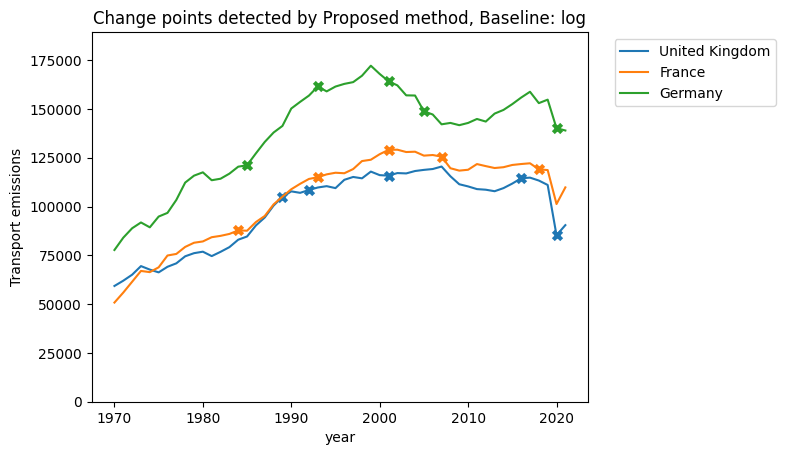

In [ ]:
function_plot_result_multiple_countries(df, df_result_spec2_our, df_result_spec2_our.country.tolist()[:3], "Proposed method, Baseline: log")

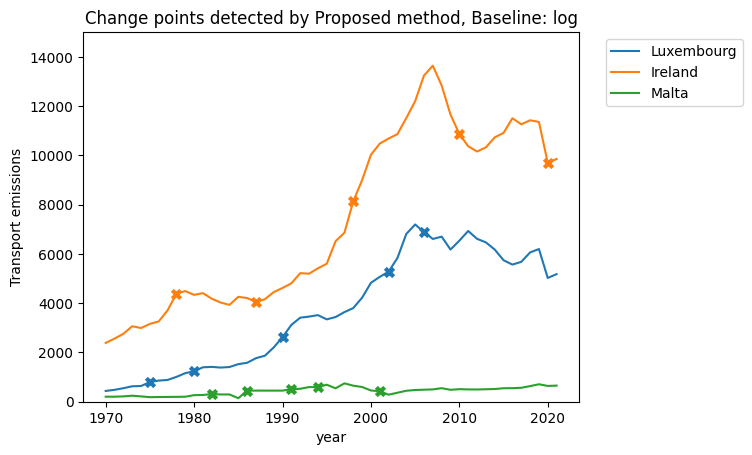

In [ ]:
function_plot_result_multiple_countries(df, df_result_spec2_our, df_result_spec2_our.country.tolist()[3:], "Proposed method, Baseline: log")

In [ ]:
# function_plot_result_multiple_countries(df, df_result_spec2_our_quad, df_result_spec2_our_quad.country.tolist()[:3], "Proposed method, quadratic penalty: log")

In [ ]:
# function_plot_result_multiple_countries(df, df_result_spec2_our_quad, df_result_spec2_our_quad.country.tolist()[3:], "Proposed method, quadratic penalty: log")

In [ ]:
# function_plot_result_multiple_countries(df, df_result_spec2_our_sqBigM, df_result_spec2_our_sqBigM.country.tolist()[:3], "Proposed method, squared BigM: log")

In [ ]:
# function_plot_result_multiple_countries(df, df_result_spec2_our_sqBigM, df_result_spec2_our_sqBigM.country.tolist()[:3], "Proposed method, squared BigM: log")

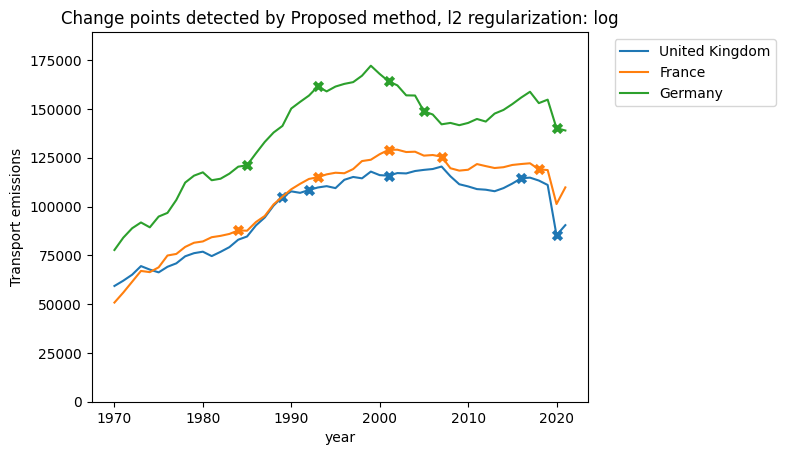

In [ ]:
function_plot_result_multiple_countries(df, df_result_spec2_our_l2reg, df_result_spec2_our_l2reg.country.tolist()[:3], "Proposed method, l2 regularization: log")

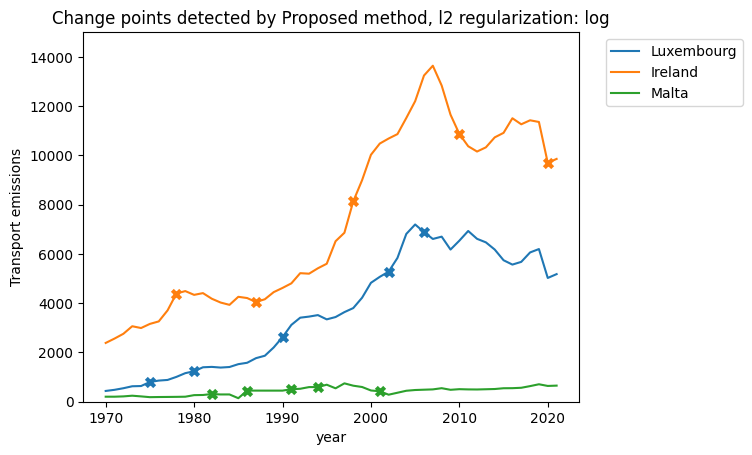

In [ ]:
function_plot_result_multiple_countries(df, df_result_spec2_our_l2reg, df_result_spec2_our_l2reg.country.tolist()[3:], "Proposed method, l2 regularization: log")

### Bai and Perron

In [ ]:
df_result_spec2_BP = function_estimation_bai_perron(dataset = df_estimation, Y_name = "log_transport.emissions", X_name = ["log_gdp", "log_pop"], countries = country_6, max_cp=5, min_seg_size = 3)
df_result_spec2_BP

<ipython-input-7-d71223445605>:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_data[col] = (X_data[col] - X_data[col].mean()) / X_data[col].std()
<ipython-input-7-d71223445605>:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_data[col] = (X_data[col] - X_data[col].mean()) / X_data[col].std()
<ipython-input-7-d71223445605>:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

,country,optimal_number,optimal_change_point_year,RSS
0,United Kingdom,3,"[1990, 2000, 2016]",0.224623
1,France,3,"[1993, 1999, 2018]",0.562853
2,Germany,5,"[1985, 1993, 2002, 2010, 2017]",0.835692
3,Luxembourg,3,"[1975, 1980, 1990]",0.272789
4,Ireland,5,"[1978, 1987, 1998, 2010, 2019]",0.170721
5,Malta,5,"[1985, 1988, 1993, 2000, 2004]",2.445801


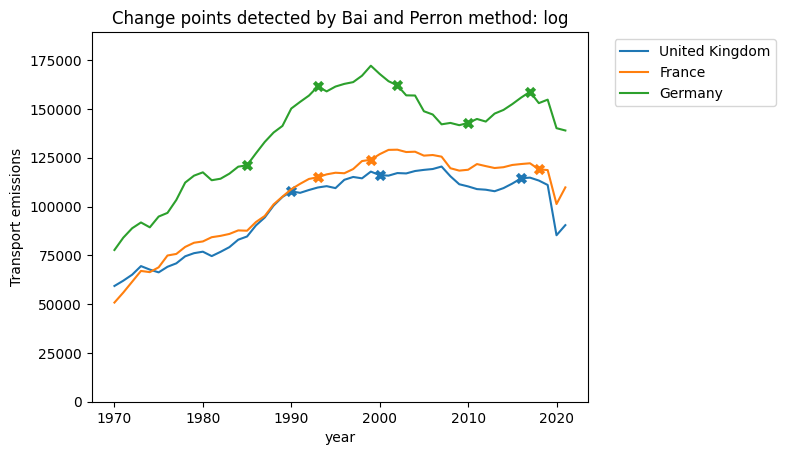

In [ ]:
function_plot_result_multiple_countries(df, df_result_spec2_BP, df_result_spec2_BP.country.tolist()[:3], "Bai and Perron method: log")

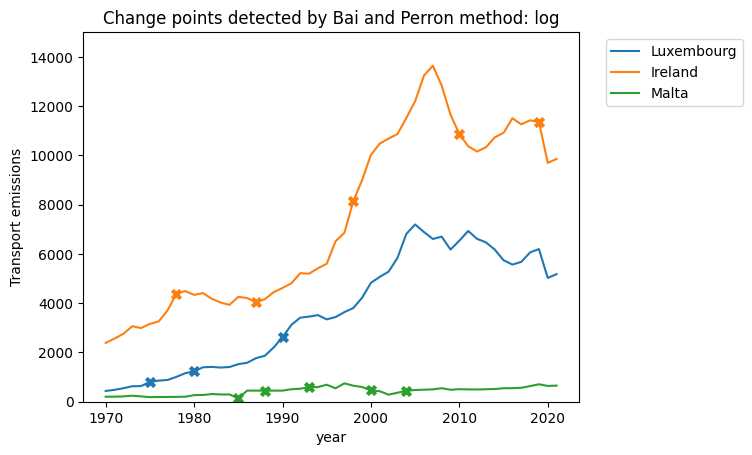

In [ ]:
function_plot_result_multiple_countries(df, df_result_spec2_BP, df_result_spec2_BP.country.tolist()[3:], "Bai and Perron method: log")

### Comparison

In [ ]:
df_result_spec2_our["method"] = "Baseline"
#df_result_spec2_our_quad["method"] = "Quadratic Penalty"
#df_result_spec2_our_sqBigM["method"] = "Squared BigM"
df_result_spec2_our_l2reg["method"] = "l2 regularization"
df_result_spec2_BP["method"] = "Bai and Perron"

#df_result_spec2_all = pd.concat([df_result_spec2_our, df_result_spec2_our_quad, df_result_spec2_our_sqBigM, df_result_spec2_our_l2reg, df_result_spec2_BP], axis = 0)
df_result_spec2_all = pd.concat([df_result_spec2_our, df_result_spec2_our_l2reg, df_result_spec2_BP], axis = 0)

In [ ]:
# df_result_spec2_all.to_csv('df_result_spec2_all.csv',index=False)

Text(0.5, 1.0, 'United Kingdom , log-specification')

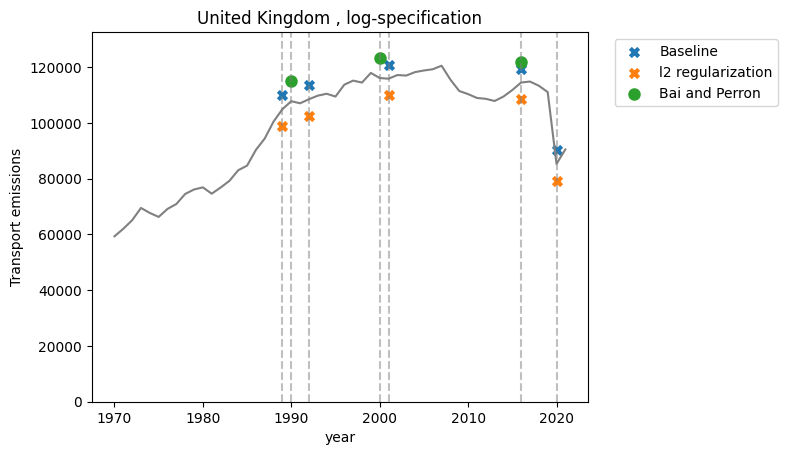

In [ ]:
country_plot = "United Kingdom"

plt.plot(df.loc[df["country"] == country_plot, "year"], df.loc[df["country"] == country_plot, "transport.emissions"], color = "gray")

store_year_change_point = []

for i in range(len(df_result_spec2_all.method.unique())):
  item = df_result_spec2_all.method.unique()[i]
  year_change_point = df_result_spec2_all.loc[(df_result_spec2_all["country"] == country_plot) & (df_result_spec2_all["method"] == item), "optimal_change_point_year"].tolist()[0]
  corresponding_emission = df.loc[(df["country"] == country_plot) & (df["year"].isin(map(float, year_change_point))) , "transport.emissions"]
  corresponding_emission = corresponding_emission + (5000*((-1.2)**(i)))
  if (item == "Bai and Perron"):
    plt.scatter(year_change_point, corresponding_emission, marker = "o", linewidths = 3, label = item)
  else:
    plt.scatter(year_change_point, corresponding_emission, marker = "x", linewidths = 3, label = item)
  store_year_change_point = store_year_change_point + year_change_point

for j in np.unique(np.array(store_year_change_point)):
  plt.axvline(x = j, color = "gray", linestyle = "--", alpha = .5) # I want to change the alpha depending on how many methods detect it.

plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.ylim((0,df.loc[df["country"] == country_plot, "transport.emissions"].max()*1.1))
plt.xlabel("year")
plt.ylabel("Transport emissions")
plt.title(country_plot + " , log-specification")

Text(0.5, 1.0, 'France , log-specification')

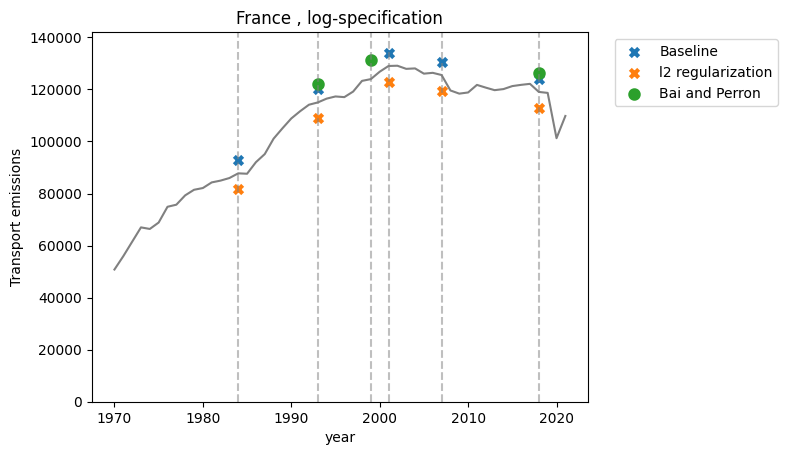

In [ ]:
country_plot = "France"

plt.plot(df.loc[df["country"] == country_plot, "year"], df.loc[df["country"] == country_plot, "transport.emissions"], color = "gray")

store_year_change_point = []

for i in range(len(df_result_spec2_all.method.unique())):
  item = df_result_spec2_all.method.unique()[i]
  year_change_point = df_result_spec2_all.loc[(df_result_spec2_all["country"] == country_plot) & (df_result_spec2_all["method"] == item), "optimal_change_point_year"].tolist()[0]
  corresponding_emission = df.loc[(df["country"] == country_plot) & (df["year"].isin(map(float, year_change_point))) , "transport.emissions"]
  corresponding_emission = corresponding_emission + (5000*((-1.2)**(i)))
  if (item == "Bai and Perron"):
    plt.scatter(year_change_point, corresponding_emission, marker = "o", linewidths = 3, label = item)
  else:
    plt.scatter(year_change_point, corresponding_emission, marker = "x", linewidths = 3, label = item)
  store_year_change_point = store_year_change_point + year_change_point

for j in np.unique(np.array(store_year_change_point)):
  plt.axvline(x = j, color = "gray", linestyle = "--", alpha = .5)

plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.ylim((0,df.loc[df["country"] == country_plot, "transport.emissions"].max()*1.1))
plt.xlabel("year")
plt.ylabel("Transport emissions")
plt.title(country_plot + " , log-specification")

Text(0.5, 1.0, 'Germany , log-specification')

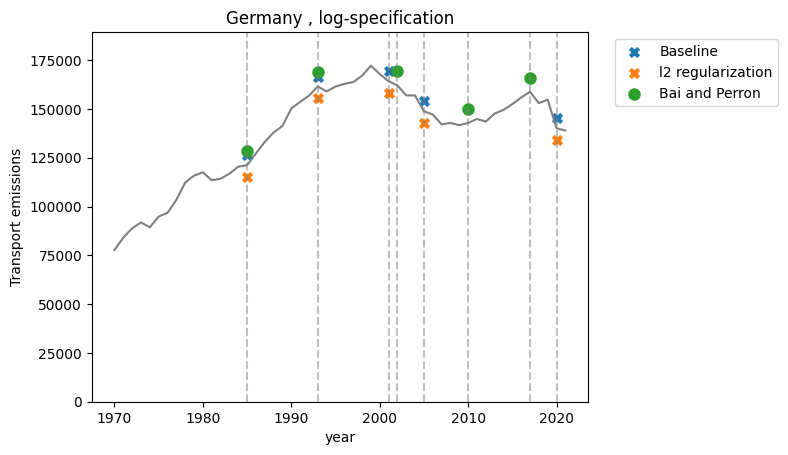

In [ ]:
country_plot = "Germany"

plt.plot(df.loc[df["country"] == country_plot, "year"], df.loc[df["country"] == country_plot, "transport.emissions"], color = "gray")

store_year_change_point = []

for i in range(len(df_result_spec2_all.method.unique())):
  item = df_result_spec2_all.method.unique()[i]
  year_change_point = df_result_spec2_all.loc[(df_result_spec2_all["country"] == country_plot) & (df_result_spec2_all["method"] == item), "optimal_change_point_year"].tolist()[0]
  corresponding_emission = df.loc[(df["country"] == country_plot) & (df["year"].isin(map(float, year_change_point))) , "transport.emissions"]
  corresponding_emission = corresponding_emission + (5000*((-1.2)**(i)))
  if (item == "Bai and Perron"):
    plt.scatter(year_change_point, corresponding_emission, marker = "o", linewidths = 3, label = item)
  else:
    plt.scatter(year_change_point, corresponding_emission, marker = "x", linewidths = 3, label = item)
  store_year_change_point = store_year_change_point + year_change_point

for j in np.unique(np.array(store_year_change_point)):
  plt.axvline(x = j, color = "gray", linestyle = "--", alpha = .5)

plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.ylim((0,df.loc[df["country"] == country_plot, "transport.emissions"].max()*1.1))
plt.xlabel("year")
plt.ylabel("Transport emissions")
plt.title(country_plot + " , log-specification")

Text(0.5, 1.0, 'Luxembourg , log-specification')

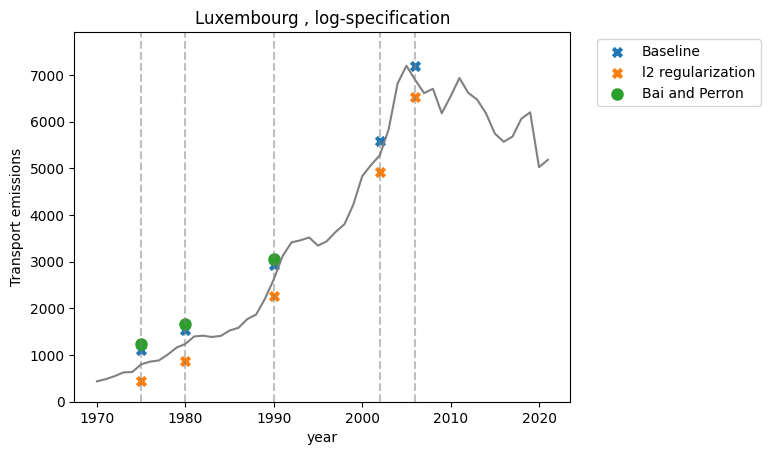

In [ ]:
country_plot = "Luxembourg"

plt.plot(df.loc[df["country"] == country_plot, "year"], df.loc[df["country"] == country_plot, "transport.emissions"], color = "gray")

store_year_change_point = []

for i in range(len(df_result_spec2_all.method.unique())):
  item = df_result_spec2_all.method.unique()[i]
  year_change_point = df_result_spec2_all.loc[(df_result_spec2_all["country"] == country_plot) & (df_result_spec2_all["method"] == item), "optimal_change_point_year"].tolist()[0]
  corresponding_emission = df.loc[(df["country"] == country_plot) & (df["year"].isin(map(float, year_change_point))) , "transport.emissions"]
  corresponding_emission = corresponding_emission + (300*((-1.2)**(i)))
  if (item == "Bai and Perron"):
    plt.scatter(year_change_point, corresponding_emission, marker = "o", linewidths = 3, label = item)
  else:
    plt.scatter(year_change_point, corresponding_emission, marker = "x", linewidths = 3, label = item)
  store_year_change_point = store_year_change_point + year_change_point

for j in np.unique(np.array(store_year_change_point)):
  plt.axvline(x = j, color = "gray", linestyle = "--", alpha = .5)

plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.ylim((0,df.loc[df["country"] == country_plot, "transport.emissions"].max()*1.1))
plt.xlabel("year")
plt.ylabel("Transport emissions")
plt.title(country_plot + " , log-specification")

Text(0.5, 1.0, 'Ireland , log-specification')

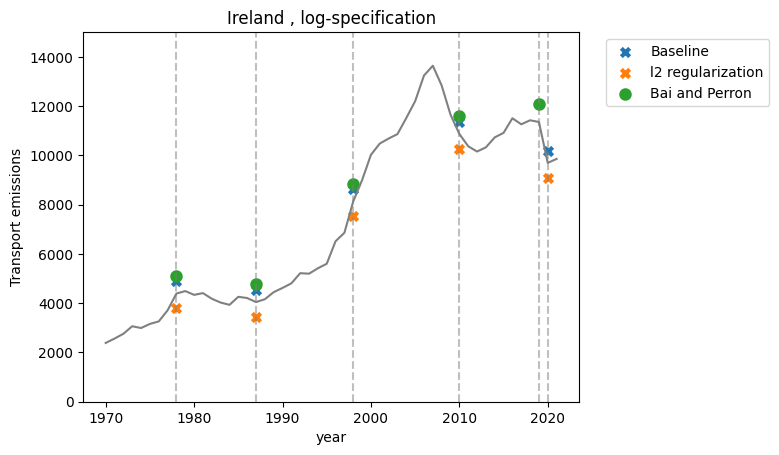

In [ ]:
country_plot = "Ireland"

plt.plot(df.loc[df["country"] == country_plot, "year"], df.loc[df["country"] == country_plot, "transport.emissions"], color = "gray")

store_year_change_point = []

for i in range(len(df_result_spec2_all.method.unique())):
  item = df_result_spec2_all.method.unique()[i]
  year_change_point = df_result_spec2_all.loc[(df_result_spec2_all["country"] == country_plot) & (df_result_spec2_all["method"] == item), "optimal_change_point_year"].tolist()[0]
  corresponding_emission = df.loc[(df["country"] == country_plot) & (df["year"].isin(map(float, year_change_point))) , "transport.emissions"]
  corresponding_emission = corresponding_emission + (500*((-1.2)**(i)))
  if (item == "Bai and Perron"):
    plt.scatter(year_change_point, corresponding_emission, marker = "o", linewidths = 3, label = item)
  else:
    plt.scatter(year_change_point, corresponding_emission, marker = "x", linewidths = 3, label = item)
  store_year_change_point = store_year_change_point + year_change_point

for j in np.unique(np.array(store_year_change_point)):
  plt.axvline(x = j, color = "gray", linestyle = "--", alpha = .5)

plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.ylim((0,df.loc[df["country"] == country_plot, "transport.emissions"].max()*1.1))
plt.xlabel("year")
plt.ylabel("Transport emissions")
plt.title(country_plot + " , log-specification")

Text(0.5, 1.0, 'Malta , log-specification')

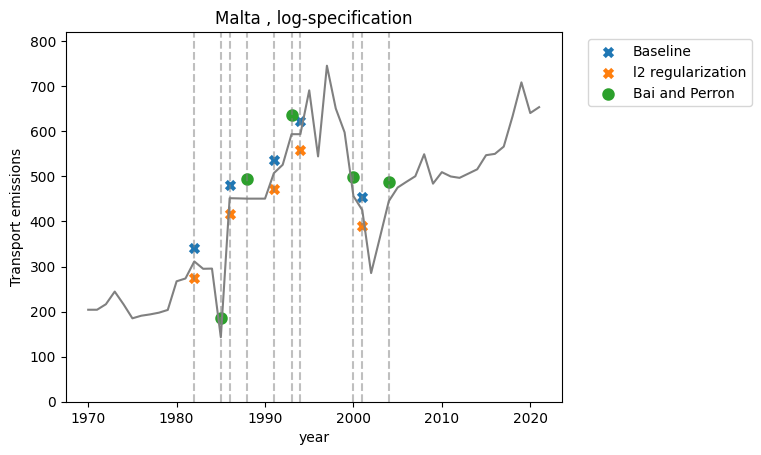

In [ ]:
country_plot = "Malta"

plt.plot(df.loc[df["country"] == country_plot, "year"], df.loc[df["country"] == country_plot, "transport.emissions"], color = "gray")

store_year_change_point = []

for i in range(len(df_result_spec2_all.method.unique())):
  item = df_result_spec2_all.method.unique()[i]
  year_change_point = df_result_spec2_all.loc[(df_result_spec2_all["country"] == country_plot) & (df_result_spec2_all["method"] == item), "optimal_change_point_year"].tolist()[0]
  corresponding_emission = df.loc[(df["country"] == country_plot) & (df["year"].isin(map(float, year_change_point))) , "transport.emissions"]
  corresponding_emission = corresponding_emission + (30*((-1.2)**(i)))
  if (item == "Bai and Perron"):
    plt.scatter(year_change_point, corresponding_emission, marker = "o", linewidths = 3, label = item)
  else:
    plt.scatter(year_change_point, corresponding_emission, marker = "x", linewidths = 3, label = item)
  store_year_change_point = store_year_change_point + year_change_point

for j in np.unique(np.array(store_year_change_point)):
  plt.axvline(x = j, color = "gray", linestyle = "--", alpha = .5)

plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.ylim((0,df.loc[df["country"] == country_plot, "transport.emissions"].max()*1.1))
plt.xlabel("year")
plt.ylabel("Transport emissions")
plt.title(country_plot + " , log-specification")

## Specification 3: log gdp, log pop, squared

In [ ]:
# df_result_spec3_our = function_estimation_our_proposed_method(dataset = df_estimation, Y_name = "log_transport.emissions", X_name = ["const", "log_gdp", "log_pop", "log_gdp_sq", "log_pop_sq"], countries = country_6)
# df_result_spec3_our

In [ ]:
# df_result_spec3_our_sqBigM = function_estimation_our_proposed_method(dataset = df_estimation, Y_name = "log_transport.emissions", X_name = ["const", "log_gdp", "log_pop", "log_gdp_sq", "log_pop_sq"], countries = country_6, squared_BigM = True)
# df_result_spec3_our_sqBigM

In [ ]:
# df_result_spec3_BP = function_estimation_bai_perron(dataset = df_estimation, Y_name = "log_transport.emissions", X_name = ["const", "log_gdp", "log_pop", "log_gdp_sq", "log_pop_sq"], countries = country_6, max_cp=5, min_seg_size = 3)
# df_result_spec3_BP

In [ ]:
# function_plot_result_multiple_countries(df_estimation, df_result_spec2_BP, df_result_spec2_BP.country.tolist()[:3], "Bai and Perron method: log-squared")

In [ ]:
# function_plot_result_multiple_countries(df_estimation, df_result_spec2_BP, df_result_spec2_BP.country.tolist()[3:], "Bai and Perron method: log-squared")

## Specification 4: log gdp, log pop, lag emission of neighbouring countries

### Proposed method

In [ ]:
df_result_spec4_our_UK = function_estimation_our_proposed_method(df_estimation, "log_transport.emissions",  ["log_gdp", "log_pop", "log_transport.emissions_lag_France", "log_transport.emissions_lag_Germany"], ["United Kingdom"], squared_BigM = False, l2_reg = False)
df_result_spec4_our_F = function_estimation_our_proposed_method(df_estimation, "log_transport.emissions",  ["log_gdp", "log_pop", "log_transport.emissions_lag_United Kingdom", "log_transport.emissions_lag_Germany"], ["France"], squared_BigM = False, l2_reg = False)
df_result_spec4_our_G = function_estimation_our_proposed_method(df_estimation, "log_transport.emissions",  ["log_gdp", "log_pop", "log_transport.emissions_lag_United Kingdom", "log_transport.emissions_lag_France"], ["Germany"], squared_BigM = False, l2_reg = False)
df_result_spec4_our_L = function_estimation_our_proposed_method(df_estimation, "log_transport.emissions",  ["log_gdp", "log_pop", "log_transport.emissions_lag_France", "log_transport.emissions_lag_Germany", "log_transport.emissions_lag_Belgium"], ["Luxembourg"], squared_BigM = False, l2_reg = False)
df_result_spec4_our_I = function_estimation_our_proposed_method(df_estimation, "log_transport.emissions",  ["log_gdp", "log_pop", "log_transport.emissions_lag_United Kingdom"], ["Ireland"], squared_BigM = False, l2_reg = False)
df_result_spec4_our_M = function_estimation_our_proposed_method(df_estimation, "log_transport.emissions",  ["log_gdp", "log_pop", "log_transport.emissions_lag_Italy"], ["Malta"], squared_BigM = False, l2_reg = False)

df_result_spec4_our = pd.concat([df_result_spec4_our_UK, df_result_spec4_our_F, df_result_spec4_our_G, df_result_spec4_our_L, df_result_spec4_our_I, df_result_spec4_our_M], ignore_index=True)
df_result_spec4_our

<ipython-input-6-8aa668e44e86>:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_data[col] = (X_data[col] - X_data[col].mean()) / X_data[col].std()


Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Academic license - for non-commercial use only - registered to toza0004@student.monash.edu
Optimize a model with 449 rows, 254 columns and 1394 nonzeros
Model fingerprint: 0xbefc322d
Model has 510 quadratic objective terms
Variable types: 204 continuous, 50 integer (50 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+01]
  Objective range  [5e-03, 1e+01]
  QObjective range [1e-04, 3e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+00]
Found heuristic solution: objective 50.0000000
Presolve time: 0.00s
Presolved: 449 rows, 254 columns, 1394 nonzeros
Presolved model has 510 quadratic objective terms
Variable types: 204 continuous, 50 integer (50 binary)

Root relaxation: objective 6.283899e-04, 2245 iterations, 0.11 seconds (0.04 work units)

    

<ipython-input-6-8aa668e44e86>:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_data[col] = (X_data[col] - X_data[col].mean()) / X_data[col].std()


Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Academic license - for non-commercial use only - registered to toza0004@student.monash.edu
Optimize a model with 449 rows, 254 columns and 1394 nonzeros
Model fingerprint: 0xe86b13d6
Model has 510 quadratic objective terms
Variable types: 204 continuous, 50 integer (50 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+01]
  Objective range  [4e-05, 1e+01]
  QObjective range [2e-09, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+00]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Found heuristic solution: objective 50.0000000
Presolve time: 0.00s
Presolved: 449 rows, 254 columns, 1394 nonzeros
Presolved model has 510 quadratic objective terms
Variable types: 204 continuous, 50 integer

<ipython-input-6-8aa668e44e86>:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_data[col] = (X_data[col] - X_data[col].mean()) / X_data[col].std()


Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Academic license - for non-commercial use only - registered to toza0004@student.monash.edu
Optimize a model with 449 rows, 254 columns and 1394 nonzeros
Model fingerprint: 0x82da36b3
Model has 510 quadratic objective terms
Variable types: 204 continuous, 50 integer (50 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+01]
  Objective range  [2e-03, 1e+01]
  QObjective range [9e-05, 3e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+00]
Found heuristic solution: objective 50.0000000
Presolve time: 0.00s
Presolved: 449 rows, 254 columns, 1394 nonzeros
Presolved model has 510 quadratic objective terms
Variable types: 204 continuous, 50 integer (50 binary)

Root relaxation: objective 7.603416e-04, 1698 iterations, 0.07 seconds (0.03 work units)

    

<ipython-input-6-8aa668e44e86>:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_data[col] = (X_data[col] - X_data[col].mean()) / X_data[col].std()


Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Academic license - for non-commercial use only - registered to toza0004@student.monash.edu
Optimize a model with 549 rows, 305 columns and 1694 nonzeros
Model fingerprint: 0xfc336a7e
Model has 765 quadratic objective terms
Variable types: 255 continuous, 50 integer (50 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+01]
  Objective range  [4e-03, 1e+01]
  QObjective range [1e-04, 3e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+00]
Found heuristic solution: objective 50.0000000
Presolve time: 0.00s
Presolved: 549 rows, 305 columns, 1694 nonzeros
Presolved model has 765 quadratic objective terms
Variable types: 255 continuous, 50 integer (50 binary)

Root relaxation: objective 3.800929e-04, 3192 iterations, 0.15 seconds (0.09 work units)

    

<ipython-input-6-8aa668e44e86>:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_data[col] = (X_data[col] - X_data[col].mean()) / X_data[col].std()


Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Academic license - for non-commercial use only - registered to toza0004@student.monash.edu
Optimize a model with 349 rows, 203 columns and 1094 nonzeros
Model fingerprint: 0x0719d6e2
Model has 306 quadratic objective terms
Variable types: 153 continuous, 50 integer (50 binary)
Coefficient statistics:
  Matrix range     [1e+00, 9e+00]
  Objective range  [3e-03, 8e+00]
  QObjective range [2e-03, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+00]
Found heuristic solution: objective 50.0000000
Presolve time: 0.00s
Presolved: 349 rows, 203 columns, 1094 nonzeros
Presolved model has 306 quadratic objective terms
Variable types: 153 continuous, 50 integer (50 binary)

Root relaxation: objective 9.929692e-04, 1366 iterations, 0.07 seconds (0.02 work units)

    

<ipython-input-6-8aa668e44e86>:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_data[col] = (X_data[col] - X_data[col].mean()) / X_data[col].std()


Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Academic license - for non-commercial use only - registered to toza0004@student.monash.edu
Optimize a model with 349 rows, 203 columns and 1094 nonzeros
Model fingerprint: 0x8eca913d
Model has 306 quadratic objective terms
Variable types: 153 continuous, 50 integer (50 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [5e-03, 8e+00]
  QObjective range [2e-04, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+00]
Found heuristic solution: objective 50.0000000
Presolve time: 0.00s
Presolved: 349 rows, 203 columns, 1094 nonzeros
Presolved model has 306 quadratic objective terms
Variable types: 153 continuous, 50 integer (50 binary)

Root relaxation: objective 2.629894e-03, 780 iterations, 0.03 seconds (0.01 work units)

    N

,country,optimal_number,optimal_change_point_year,optimality_gap,RSS
0,United Kingdom,5,"[1984, 1988, 1995, 2000, 2016]",0.520725,0.033650
1,France,5,"[1975, 1986, 2001, 2008, 2018]",0.568375,0.034982
2,Germany,5,"[1976, 1983, 2002, 2007, 2016]",0.850507,0.178235
3,Luxembourg,5,"[1982, 1995, 2004, 2011, 2017]",0.266826,0.033490
4,Ireland,5,"[1978, 1987, 1996, 2010, 2020]",0.000000,0.112908
5,Malta,5,"[1983, 1986, 1997, 2002, 2006]",0.000000,0.767213


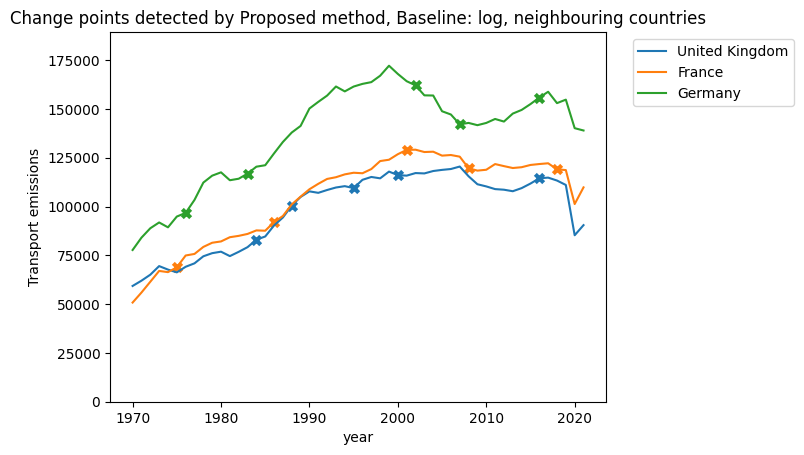

In [ ]:
function_plot_result_multiple_countries(df, df_result_spec4_our, df_result_spec4_our.country.tolist()[:3], "Proposed method, Baseline: log, neighbouring countries")

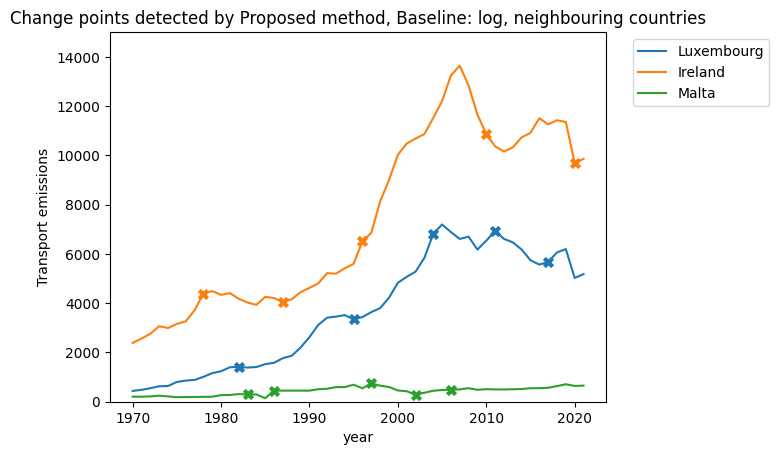

In [ ]:
function_plot_result_multiple_countries(df, df_result_spec4_our, df_result_spec4_our.country.tolist()[3:], "Proposed method, Baseline: log, neighbouring countries")

In [ ]:
# df_result_spec4_our_quad_UK = function_estimation_our_proposed_method(df_estimation, "log_transport.emissions",  ["log_gdp", "log_pop", "log_transport.emissions_lag_France", "log_transport.emissions_lag_Germany"], ["United Kingdom"], quadratic_penalty= True, squared_BigM = False, l2_reg = False)
# df_result_spec4_our_quad_F = function_estimation_our_proposed_method(df_estimation, "log_transport.emissions",  ["log_gdp", "log_pop", "log_transport.emissions_lag_United Kingdom", "log_transport.emissions_lag_Germany"], ["France"], quadratic_penalty= True, squared_BigM = False, l2_reg = False)
# df_result_spec4_our_quad_G = function_estimation_our_proposed_method(df_estimation, "log_transport.emissions",  ["log_gdp", "log_pop", "log_transport.emissions_lag_United Kingdom", "log_transport.emissions_lag_France"], ["Germany"], quadratic_penalty= True, squared_BigM = False, l2_reg = False)
# df_result_spec4_our_quad_L = function_estimation_our_proposed_method(df_estimation, "log_transport.emissions",  ["log_gdp", "log_pop", "log_transport.emissions_lag_France", "log_transport.emissions_lag_Germany", "log_transport.emissions_lag_Belgium"], ["Luxembourg"], quadratic_penalty= True, squared_BigM = False, l2_reg = False)
# df_result_spec4_our_quad_I = function_estimation_our_proposed_method(df_estimation, "log_transport.emissions",  ["log_gdp", "log_pop", "log_transport.emissions_lag_United Kingdom"], ["Ireland"], quadratic_penalty= True, squared_BigM = False, l2_reg = False)
# df_result_spec4_our_quad_M = function_estimation_our_proposed_method(df_estimation, "log_transport.emissions",  ["log_gdp", "log_pop", "log_transport.emissions_lag_Italy"], ["Malta"], quadratic_penalty= True, squared_BigM = False, l2_reg = False)

# df_result_spec4_our_quad = pd.concat([df_result_spec4_our_quad_UK, df_result_spec4_our_quad_F, df_result_spec4_our_quad_G, df_result_spec4_our_quad_L, df_result_spec4_our_quad_I, df_result_spec4_our_quad_M], ignore_index=True)
# df_result_spec4_our_quad

In [ ]:
# function_plot_result_multiple_countries(df, df_result_spec4_our_quad, df_result_spec4_our_quad.country.tolist()[:3], "Proposed method, quadratic penalty: log, neighbouring countries")

In [ ]:
# function_plot_result_multiple_countries(df, df_result_spec4_our_quad, df_result_spec4_our_quad.country.tolist()[3:], "Proposed method, quadratic penalty: log, neighbouring countries")

In [ ]:
# df_result_spec4_our_sqBigM_UK = function_estimation_our_proposed_method(df_estimation, "log_transport.emissions",  ["log_gdp", "log_pop", "log_transport.emissions_lag_France", "log_transport.emissions_lag_Germany"], ["United Kingdom"], squared_BigM = True, l2_reg = False)
# df_result_spec4_our_sqBigM_F = function_estimation_our_proposed_method(df_estimation, "log_transport.emissions",  ["log_gdp", "log_pop", "log_transport.emissions_lag_United Kingdom", "log_transport.emissions_lag_Germany"], ["France"], squared_BigM = True, l2_reg = False)
# df_result_spec4_our_sqBigM_G = function_estimation_our_proposed_method(df_estimation, "log_transport.emissions",  ["log_gdp", "log_pop", "log_transport.emissions_lag_United Kingdom", "log_transport.emissions_lag_France"], ["Germany"], squared_BigM = True, l2_reg = False)
# df_result_spec4_our_sqBigM_L = function_estimation_our_proposed_method(df_estimation, "log_transport.emissions",  ["log_gdp", "log_pop", "log_transport.emissions_lag_France", "log_transport.emissions_lag_Germany", "log_transport.emissions_lag_Belgium"], ["Luxembourg"], squared_BigM = True, l2_reg = False)
# df_result_spec4_our_sqBigM_I = function_estimation_our_proposed_method(df_estimation, "log_transport.emissions",  ["log_gdp", "log_pop", "log_transport.emissions_lag_United Kingdom"], ["Ireland"], squared_BigM = True, l2_reg = False)
# df_result_spec4_our_sqBigM_M = function_estimation_our_proposed_method(df_estimation, "log_transport.emissions",  ["log_gdp", "log_pop", "log_transport.emissions_lag_Italy"], ["Malta"], squared_BigM = True, l2_reg = False)

# df_result_spec4_our_sqBigM = pd.concat([df_result_spec4_our_sqBigM_UK, df_result_spec4_our_sqBigM_F, df_result_spec4_our_sqBigM_G, df_result_spec4_our_sqBigM_L, df_result_spec4_our_sqBigM_I, df_result_spec4_our_sqBigM_M], ignore_index=True)
# df_result_spec4_our_sqBigM

In [ ]:
# function_plot_result_multiple_countries(df, df_result_spec4_our_sqBigM, df_result_spec4_our_sqBigM.country.tolist()[:3], "Proposed method, squared BigM: log, neighbouring countries")

In [ ]:
# function_plot_result_multiple_countries(df, df_result_spec4_our_sqBigM, df_result_spec4_our_sqBigM.country.tolist()[3:], "Proposed method, squared BigM: log, neighbouring countries")

In [ ]:
df_result_spec4_our_reg_UK = function_estimation_our_proposed_method(df_estimation, "log_transport.emissions",  ["log_gdp", "log_pop", "log_transport.emissions_lag_France", "log_transport.emissions_lag_Germany"], ["United Kingdom"], squared_BigM = False, l2_reg = True)
df_result_spec4_our_reg_F = function_estimation_our_proposed_method(df_estimation, "log_transport.emissions",  ["log_gdp", "log_pop", "log_transport.emissions_lag_United Kingdom", "log_transport.emissions_lag_Germany"], ["France"], squared_BigM = False, l2_reg = True)
df_result_spec4_our_reg_G = function_estimation_our_proposed_method(df_estimation, "log_transport.emissions",  ["log_gdp", "log_pop", "log_transport.emissions_lag_United Kingdom", "log_transport.emissions_lag_France"], ["Germany"], squared_BigM = False, l2_reg = True)
df_result_spec4_our_reg_L = function_estimation_our_proposed_method(df_estimation, "log_transport.emissions",  ["log_gdp", "log_pop", "log_transport.emissions_lag_France", "log_transport.emissions_lag_Germany", "log_transport.emissions_lag_Belgium"], ["Luxembourg"], squared_BigM = False, l2_reg = True)
df_result_spec4_our_reg_I = function_estimation_our_proposed_method(df_estimation, "log_transport.emissions",  ["log_gdp", "log_pop", "log_transport.emissions_lag_United Kingdom"], ["Ireland"], squared_BigM = False, l2_reg = True)
df_result_spec4_our_reg_M = function_estimation_our_proposed_method(df_estimation, "log_transport.emissions",  ["log_gdp", "log_pop", "log_transport.emissions_lag_Italy"], ["Malta"], squared_BigM = False, l2_reg = True)

df_result_spec4_our_reg = pd.concat([df_result_spec4_our_reg_UK, df_result_spec4_our_reg_F, df_result_spec4_our_reg_G, df_result_spec4_our_reg_L, df_result_spec4_our_reg_I, df_result_spec4_our_reg_M], ignore_index=True)
df_result_spec4_our_reg

<ipython-input-6-8aa668e44e86>:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_data[col] = (X_data[col] - X_data[col].mean()) / X_data[col].std()


Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Academic license - for non-commercial use only - registered to toza0004@student.monash.edu
Optimize a model with 449 rows, 254 columns and 1394 nonzeros
Model fingerprint: 0x006f0499
Model has 510 quadratic objective terms
Variable types: 204 continuous, 50 integer (50 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+01]
  Objective range  [5e-03, 1e+01]
  QObjective range [1e-04, 3e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+00]
Found heuristic solution: objective 50.0000000
Presolve time: 0.00s
Presolved: 449 rows, 254 columns, 1394 nonzeros
Presolved model has 510 quadratic objective terms
Variable types: 204 continuous, 50 integer (50 binary)

Root relaxation: objective 8.898077e-04, 2066 iterations, 0.10 seconds (0.05 work units)

    

<ipython-input-6-8aa668e44e86>:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_data[col] = (X_data[col] - X_data[col].mean()) / X_data[col].std()


Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Academic license - for non-commercial use only - registered to toza0004@student.monash.edu
Optimize a model with 449 rows, 254 columns and 1394 nonzeros
Model fingerprint: 0xc88eae8c
Model has 510 quadratic objective terms
Variable types: 204 continuous, 50 integer (50 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+01]
  Objective range  [4e-05, 1e+01]
  QObjective range [1e-05, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+00]
Found heuristic solution: objective 50.0000000
Presolve time: 0.00s
Presolved: 449 rows, 254 columns, 1394 nonzeros
Presolved model has 510 quadratic objective terms
Variable types: 204 continuous, 50 integer (50 binary)

Root relaxation: objective 7.121211e-04, 1744 iterations, 0.08 seconds (0.04 work units)

    

<ipython-input-6-8aa668e44e86>:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_data[col] = (X_data[col] - X_data[col].mean()) / X_data[col].std()


Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Academic license - for non-commercial use only - registered to toza0004@student.monash.edu
Optimize a model with 449 rows, 254 columns and 1394 nonzeros
Model fingerprint: 0x82fbc27a
Model has 510 quadratic objective terms
Variable types: 204 continuous, 50 integer (50 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+01]
  Objective range  [2e-03, 1e+01]
  QObjective range [1e-04, 3e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+00]
Found heuristic solution: objective 50.0000000
Presolve time: 0.00s
Presolved: 449 rows, 254 columns, 1394 nonzeros
Presolved model has 510 quadratic objective terms
Variable types: 204 continuous, 50 integer (50 binary)

Root relaxation: objective 9.135996e-04, 1630 iterations, 0.07 seconds (0.04 work units)

    

<ipython-input-6-8aa668e44e86>:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_data[col] = (X_data[col] - X_data[col].mean()) / X_data[col].std()


Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Academic license - for non-commercial use only - registered to toza0004@student.monash.edu
Optimize a model with 549 rows, 305 columns and 1694 nonzeros
Model fingerprint: 0x36068eb0
Model has 765 quadratic objective terms
Variable types: 255 continuous, 50 integer (50 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+01]
  Objective range  [4e-03, 1e+01]
  QObjective range [1e-04, 3e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+00]
Found heuristic solution: objective 50.0000000
Presolve time: 0.00s
Presolved: 549 rows, 305 columns, 1694 nonzeros
Presolved model has 765 quadratic objective terms
Variable types: 255 continuous, 50 integer (50 binary)

Root relaxation: objective 4.738794e-04, 3347 iterations, 0.17 seconds (0.11 work units)

    

<ipython-input-6-8aa668e44e86>:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_data[col] = (X_data[col] - X_data[col].mean()) / X_data[col].std()


Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Academic license - for non-commercial use only - registered to toza0004@student.monash.edu
Optimize a model with 349 rows, 203 columns and 1094 nonzeros
Model fingerprint: 0xf2ec6f61
Model has 306 quadratic objective terms
Variable types: 153 continuous, 50 integer (50 binary)
Coefficient statistics:
  Matrix range     [1e+00, 9e+00]
  Objective range  [3e-03, 8e+00]
  QObjective range [2e-03, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+00]
Found heuristic solution: objective 50.0000000
Presolve time: 0.00s
Presolved: 349 rows, 203 columns, 1094 nonzeros
Presolved model has 306 quadratic objective terms
Variable types: 153 continuous, 50 integer (50 binary)

Root relaxation: objective 1.192005e-03, 1374 iterations, 0.04 seconds (0.02 work units)

    

<ipython-input-6-8aa668e44e86>:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_data[col] = (X_data[col] - X_data[col].mean()) / X_data[col].std()


Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Academic license - for non-commercial use only - registered to toza0004@student.monash.edu
Optimize a model with 349 rows, 203 columns and 1094 nonzeros
Model fingerprint: 0x0ebc22ba
Model has 306 quadratic objective terms
Variable types: 153 continuous, 50 integer (50 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [5e-03, 8e+00]
  QObjective range [2e-04, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+00]
Found heuristic solution: objective 50.0000000
Presolve time: 0.00s
Presolved: 349 rows, 203 columns, 1094 nonzeros
Presolved model has 306 quadratic objective terms
Variable types: 153 continuous, 50 integer (50 binary)

Root relaxation: objective 2.988826e-03, 719 iterations, 0.03 seconds (0.01 work units)

    N

,country,optimal_number,optimal_change_point_year,optimality_gap,RSS
0,United Kingdom,5,"[1984, 1988, 1995, 2000, 2016]",0.000087,0.034179
1,France,5,"[1975, 1986, 2001, 2008, 2018]",0.000000,0.034987
2,Germany,5,"[1976, 1983, 2002, 2007, 2016]",0.000000,0.178262
3,Luxembourg,5,"[1982, 1995, 2004, 2011, 2017]",0.000032,0.033732
4,Ireland,5,"[1978, 1987, 1996, 2010, 2020]",0.000000,0.112909
5,Malta,5,"[1983, 1986, 1997, 2002, 2006]",0.000000,0.767220


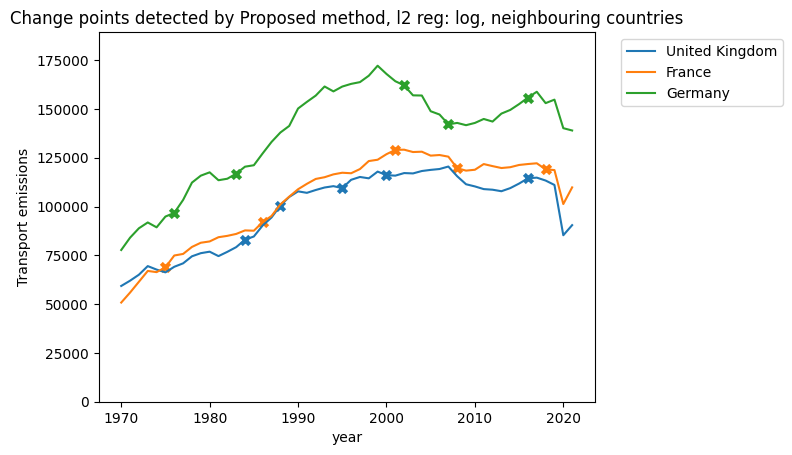

In [ ]:
function_plot_result_multiple_countries(df, df_result_spec4_our_reg, df_result_spec4_our_reg.country.tolist()[:3], "Proposed method, l2 reg: log, neighbouring countries")

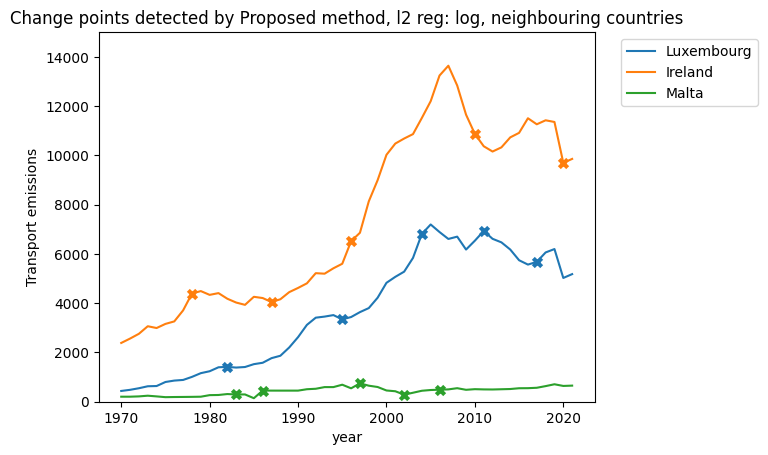

In [ ]:
function_plot_result_multiple_countries(df, df_result_spec4_our_reg, df_result_spec4_our_reg.country.tolist()[3:], "Proposed method, l2 reg: log, neighbouring countries")

### Bai and Perron

In [ ]:
df_result_spec4_BP_UK = function_estimation_bai_perron(df_estimation, "log_transport.emissions",  ["log_gdp", "log_pop", "log_transport.emissions_lag_France", "log_transport.emissions_lag_Germany"], ["United Kingdom"], max_cp=5, min_seg_size = 3)
df_result_spec4_BP_F = function_estimation_bai_perron(df_estimation, "log_transport.emissions",  ["log_gdp", "log_pop", "log_transport.emissions_lag_United Kingdom", "log_transport.emissions_lag_Germany"], ["France"], max_cp=5, min_seg_size = 3)
df_result_spec4_BP_G = function_estimation_bai_perron(df_estimation, "log_transport.emissions",  ["log_gdp", "log_pop", "log_transport.emissions_lag_United Kingdom", "log_transport.emissions_lag_France"], ["Germany"], max_cp=5, min_seg_size = 3)
df_result_spec4_BP_L = function_estimation_bai_perron(df_estimation, "log_transport.emissions",  ["log_gdp", "log_pop", "log_transport.emissions_lag_France", "log_transport.emissions_lag_Germany", "log_transport.emissions_lag_Belgium"], ["Luxembourg"], max_cp=5, min_seg_size = 3)
df_result_spec4_BP_I = function_estimation_bai_perron(df_estimation, "log_transport.emissions",  ["log_gdp", "log_pop", "log_transport.emissions_lag_United Kingdom"], ["Ireland"], max_cp=5, min_seg_size = 3)
df_result_spec4_BP_M = function_estimation_bai_perron(df_estimation, "log_transport.emissions",  ["log_gdp", "log_pop", "log_transport.emissions_lag_Italy"], ["Malta"], max_cp=5, min_seg_size = 3)

df_result_spec4_BP = pd.concat([df_result_spec4_BP_UK, df_result_spec4_BP_F, df_result_spec4_BP_G, df_result_spec4_BP_L, df_result_spec4_BP_I, df_result_spec4_BP_M], ignore_index=True)
df_result_spec4_BP

<ipython-input-7-d71223445605>:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_data[col] = (X_data[col] - X_data[col].mean()) / X_data[col].std()
<ipython-input-7-d71223445605>:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_data[col] = (X_data[col] - X_data[col].mean()) / X_data[col].std()
<ipython-input-7-d71223445605>:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

,country,optimal_number,optimal_change_point_year,RSS
0,United Kingdom,4,"[1986, 1995, 2000, 2016]",0.049165
1,France,5,"[1975, 1986, 2001, 2008, 2018]",0.034982
2,Germany,5,"[1976, 1983, 2002, 2007, 2016]",0.178235
3,Luxembourg,5,"[1982, 1995, 2004, 2011, 2017]",0.033490
4,Ireland,5,"[1978, 1987, 1996, 2010, 2019]",0.105826
5,Malta,5,"[1985, 1988, 1997, 2002, 2005]",0.700813


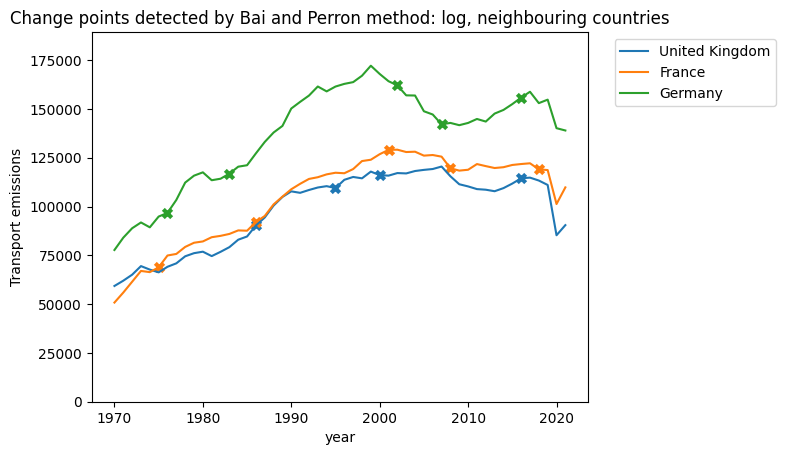

In [ ]:
function_plot_result_multiple_countries(df, df_result_spec4_BP, df_result_spec4_BP.country.tolist()[:3], "Bai and Perron method: log, neighbouring countries")

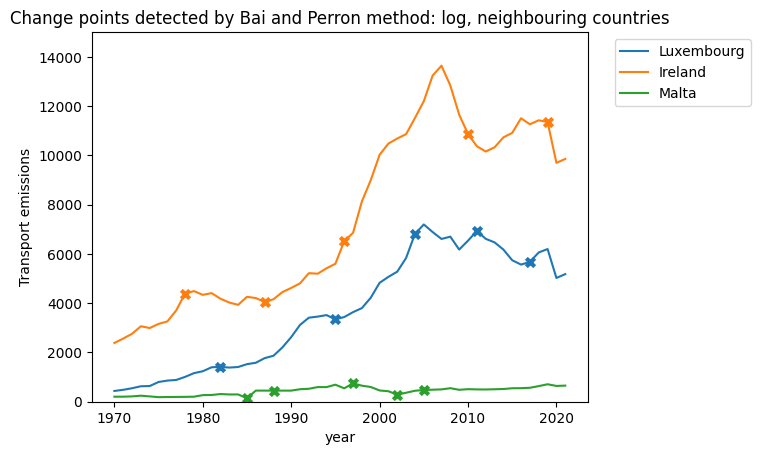

In [ ]:
function_plot_result_multiple_countries(df, df_result_spec4_BP, df_result_spec4_BP.country.tolist()[3:], "Bai and Perron method: log, neighbouring countries")

### Comparison

In [ ]:
df_result_spec4_our["method"] = "Baseline"
#df_result_spec4_our_quad["method"] = "Quadratic Penalty"
#df_result_spec4_our_sqBigM["method"] = "Squared BigM"
df_result_spec4_our_reg["method"] = "l2 regularization"
df_result_spec4_BP["method"] = "Bai and Perron"

#df_result_spec4_all = pd.concat([df_result_spec4_our, df_result_spec4_our_quad, df_result_spec4_our_sqBigM, df_result_spec4_our_reg, df_result_spec4_BP], axis = 0)
df_result_spec4_all = pd.concat([df_result_spec4_our, df_result_spec4_our_reg, df_result_spec4_BP], axis = 0)

In [ ]:
# df_result_spec4_all.to_csv('df_result_spec4_all.csv',index=False)

Text(0.5, 1.0, 'United Kingdom , log-specification with neighbouring countries')

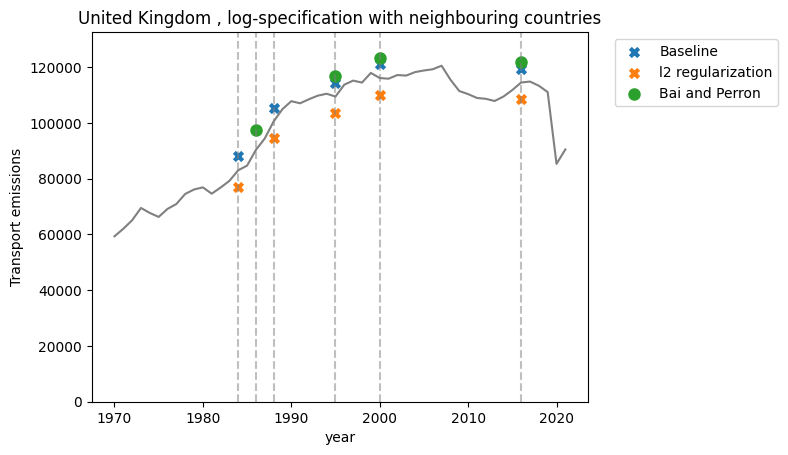

In [ ]:
country_plot = "United Kingdom"

plt.plot(df.loc[df["country"] == country_plot, "year"], df.loc[df["country"] == country_plot, "transport.emissions"], color = "gray")

store_year_change_point = []

for i in range(len(df_result_spec4_all.method.unique())):
  item = df_result_spec4_all.method.unique()[i]
  year_change_point = df_result_spec4_all.loc[(df_result_spec4_all["country"] == country_plot) & (df_result_spec4_all["method"] == item), "optimal_change_point_year"].tolist()[0]
  corresponding_emission = df.loc[(df["country"] == country_plot) & (df["year"].isin(map(float, year_change_point))) , "transport.emissions"]
  corresponding_emission = corresponding_emission + (5000*((-1.2)**(i)))
  if (item == "Bai and Perron"):
    plt.scatter(year_change_point, corresponding_emission, marker = "o", linewidths = 3, label = item)
  else:
    plt.scatter(year_change_point, corresponding_emission, marker = "x", linewidths = 3, label = item)
  store_year_change_point = store_year_change_point + year_change_point

for j in np.unique(np.array(store_year_change_point)):
  plt.axvline(x = j, color = "gray", linestyle = "--", alpha = .5)

plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.ylim((0,df.loc[df["country"] == country_plot, "transport.emissions"].max()*1.1))
plt.xlabel("year")
plt.ylabel("Transport emissions")
plt.title(country_plot + " , log-specification with neighbouring countries")

Text(0.5, 1.0, 'France , log-specification with neighbouring countries')

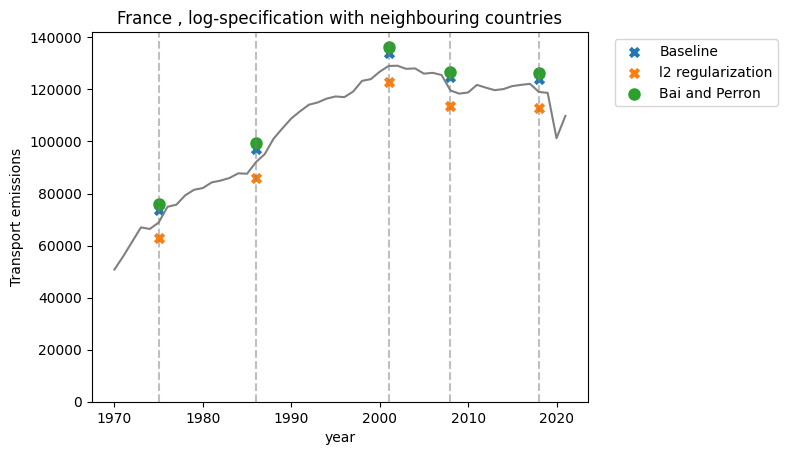

In [ ]:
country_plot = "France"

plt.plot(df.loc[df["country"] == country_plot, "year"], df.loc[df["country"] == country_plot, "transport.emissions"], color = "gray")

store_year_change_point = []

for i in range(len(df_result_spec4_all.method.unique())):
  item = df_result_spec4_all.method.unique()[i]
  year_change_point = df_result_spec4_all.loc[(df_result_spec4_all["country"] == country_plot) & (df_result_spec4_all["method"] == item), "optimal_change_point_year"].tolist()[0]
  corresponding_emission = df.loc[(df["country"] == country_plot) & (df["year"].isin(map(float, year_change_point))) , "transport.emissions"]
  corresponding_emission = corresponding_emission + (5000*((-1.2)**(i)))
  if (item == "Bai and Perron"):
    plt.scatter(year_change_point, corresponding_emission, marker = "o", linewidths = 3, label = item)
  else:
    plt.scatter(year_change_point, corresponding_emission, marker = "x", linewidths = 3, label = item)
  store_year_change_point = store_year_change_point + year_change_point

for j in np.unique(np.array(store_year_change_point)):
  plt.axvline(x = j, color = "gray", linestyle = "--", alpha = .5)

plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.ylim((0,df.loc[df["country"] == country_plot, "transport.emissions"].max()*1.1))
plt.xlabel("year")
plt.ylabel("Transport emissions")
plt.title(country_plot + " , log-specification with neighbouring countries")

Text(0.5, 1.0, 'Germany , log-specification with neighbouring countries')

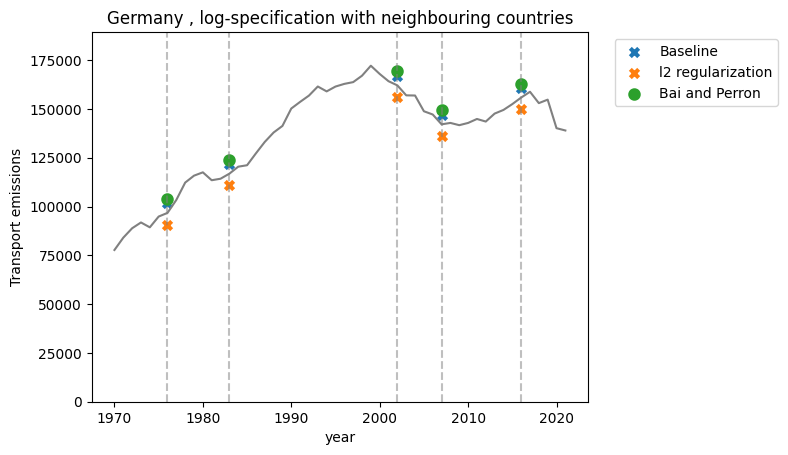

In [ ]:
country_plot = "Germany"

plt.plot(df.loc[df["country"] == country_plot, "year"], df.loc[df["country"] == country_plot, "transport.emissions"], color = "gray")

store_year_change_point = []

for i in range(len(df_result_spec4_all.method.unique())):
  item = df_result_spec4_all.method.unique()[i]
  year_change_point = df_result_spec4_all.loc[(df_result_spec4_all["country"] == country_plot) & (df_result_spec4_all["method"] == item), "optimal_change_point_year"].tolist()[0]
  corresponding_emission = df.loc[(df["country"] == country_plot) & (df["year"].isin(map(float, year_change_point))) , "transport.emissions"]
  corresponding_emission = corresponding_emission + (5000*((-1.2)**(i)))
  if (item == "Bai and Perron"):
    plt.scatter(year_change_point, corresponding_emission, marker = "o", linewidths = 3, label = item)
  else:
    plt.scatter(year_change_point, corresponding_emission, marker = "x", linewidths = 3, label = item)
  store_year_change_point = store_year_change_point + year_change_point

for j in np.unique(np.array(store_year_change_point)):
  plt.axvline(x = j, color = "gray", linestyle = "--", alpha = .5)

plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.ylim((0,df.loc[df["country"] == country_plot, "transport.emissions"].max()*1.1))
plt.xlabel("year")
plt.ylabel("Transport emissions")
plt.title(country_plot + " , log-specification with neighbouring countries")

Text(0.5, 1.0, 'Luxembourg , log-specification with neighbouring countries')

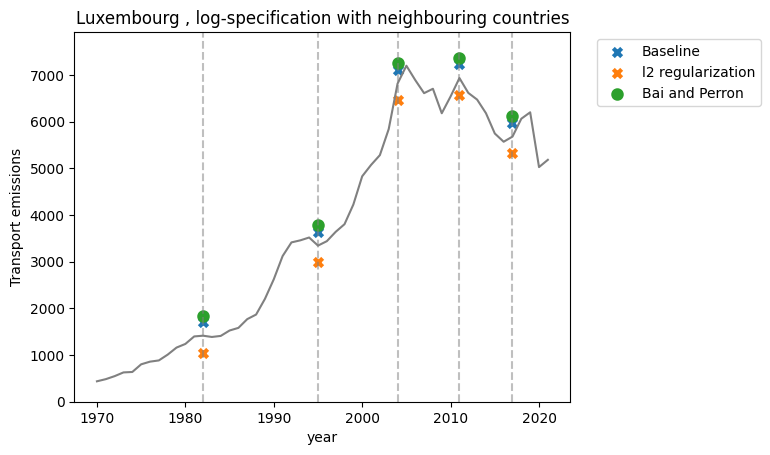

In [ ]:
country_plot = "Luxembourg"

plt.plot(df.loc[df["country"] == country_plot, "year"], df.loc[df["country"] == country_plot, "transport.emissions"], color = "gray")

store_year_change_point = []

for i in range(len(df_result_spec4_all.method.unique())):
  item = df_result_spec4_all.method.unique()[i]
  year_change_point = df_result_spec4_all.loc[(df_result_spec4_all["country"] == country_plot) & (df_result_spec4_all["method"] == item), "optimal_change_point_year"].tolist()[0]
  corresponding_emission = df.loc[(df["country"] == country_plot) & (df["year"].isin(map(float, year_change_point))) , "transport.emissions"]
  corresponding_emission = corresponding_emission + (300*((-1.2)**(i)))
  if (item == "Bai and Perron"):
    plt.scatter(year_change_point, corresponding_emission, marker = "o", linewidths = 3, label = item)
  else:
    plt.scatter(year_change_point, corresponding_emission, marker = "x", linewidths = 3, label = item)
  store_year_change_point = store_year_change_point + year_change_point

for j in np.unique(np.array(store_year_change_point)):
  plt.axvline(x = j, color = "gray", linestyle = "--", alpha = .5)

plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.ylim((0,df.loc[df["country"] == country_plot, "transport.emissions"].max()*1.1))
plt.xlabel("year")
plt.ylabel("Transport emissions")
plt.title(country_plot + " , log-specification with neighbouring countries")

Text(0.5, 1.0, 'Ireland , log-specification with neighbouring countries')

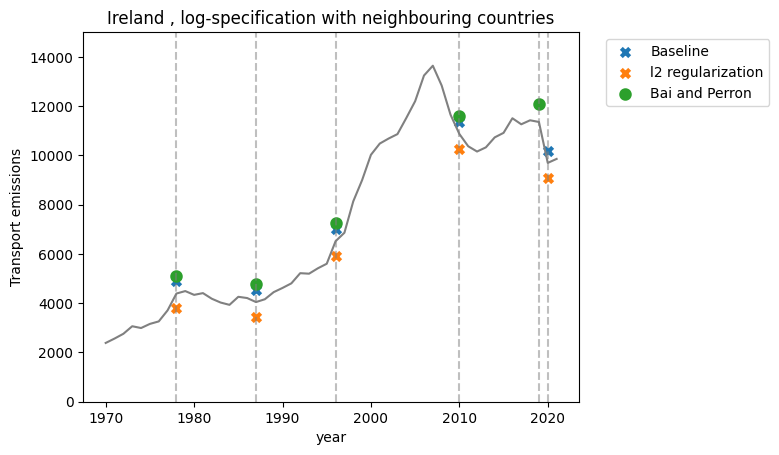

In [ ]:
country_plot = "Ireland"

plt.plot(df.loc[df["country"] == country_plot, "year"], df.loc[df["country"] == country_plot, "transport.emissions"], color = "gray")

store_year_change_point = []

for i in range(len(df_result_spec4_all.method.unique())):
  item = df_result_spec4_all.method.unique()[i]
  year_change_point = df_result_spec4_all.loc[(df_result_spec4_all["country"] == country_plot) & (df_result_spec4_all["method"] == item), "optimal_change_point_year"].tolist()[0]
  corresponding_emission = df.loc[(df["country"] == country_plot) & (df["year"].isin(map(float, year_change_point))) , "transport.emissions"]
  corresponding_emission = corresponding_emission + (500*((-1.2)**(i)))
  if (item == "Bai and Perron"):
    plt.scatter(year_change_point, corresponding_emission, marker = "o", linewidths = 3, label = item)
  else:
    plt.scatter(year_change_point, corresponding_emission, marker = "x", linewidths = 3, label = item)
  store_year_change_point = store_year_change_point + year_change_point

for j in np.unique(np.array(store_year_change_point)):
  plt.axvline(x = j, color = "gray", linestyle = "--", alpha = .5)

plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.ylim((0,df.loc[df["country"] == country_plot, "transport.emissions"].max()*1.1))
plt.xlabel("year")
plt.ylabel("Transport emissions")
plt.title(country_plot + " , log-specification with neighbouring countries")

Text(0.5, 1.0, 'Malta , log-specification with neighbouring countries')

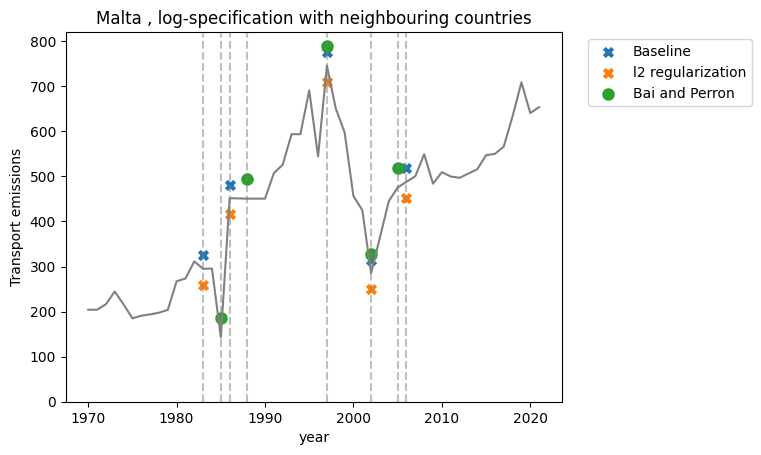

In [ ]:
country_plot = "Malta"

plt.plot(df.loc[df["country"] == country_plot, "year"], df.loc[df["country"] == country_plot, "transport.emissions"], color = "gray")

store_year_change_point = []

for i in range(len(df_result_spec4_all.method.unique())):
  item = df_result_spec4_all.method.unique()[i]
  year_change_point = df_result_spec4_all.loc[(df_result_spec4_all["country"] == country_plot) & (df_result_spec4_all["method"] == item), "optimal_change_point_year"].tolist()[0]
  corresponding_emission = df.loc[(df["country"] == country_plot) & (df["year"].isin(map(float, year_change_point))) , "transport.emissions"]
  corresponding_emission = corresponding_emission + (30*((-1.2)**(i)))
  if (item == "Bai and Perron"):
    plt.scatter(year_change_point, corresponding_emission, marker = "o", linewidths = 3, label = item)
  else:
    plt.scatter(year_change_point, corresponding_emission, marker = "x", linewidths = 3, label = item)
  store_year_change_point = store_year_change_point + year_change_point

for j in np.unique(np.array(store_year_change_point)):
  plt.axvline(x = j, color = "gray", linestyle = "--", alpha = .5)

plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.ylim((0,df.loc[df["country"] == country_plot, "transport.emissions"].max()*1.1))
plt.xlabel("year")
plt.ylabel("Transport emissions (kt)")
plt.title(country_plot + " , log-specification with neighbouring countries")

# For thesis

In [ ]:
df_result_spec2 = pd.read_csv("https://raw.githubusercontent.com/TomoyaOzawa-DA/research-project/main/EmpiricalStudy/df_result_spec2_all.csv")
df_result_spec4 = pd.read_csv("https://raw.githubusercontent.com/TomoyaOzawa-DA/research-project/main/EmpiricalStudy/df_result_spec4_all.csv")

df_result_spec4.loc[df_result_spec4["method"] == "l2 regularization",]

,country,optimal_number,optimal_change_point_year,optimality_gap,RSS,method
18,United Kingdom,5,"[1984, 1988, 1995, 2000, 2016]",0.000087,0.034179,l2 regularization
19,France,5,"[1975, 1986, 2001, 2008, 2018]",0.000000,0.034987,l2 regularization
20,Germany,5,"[1976, 1983, 2002, 2007, 2016]",0.000000,0.178262,l2 regularization
21,Luxembourg,5,"[1982, 1995, 2004, 2011, 2017]",0.000032,0.033732,l2 regularization
22,Ireland,5,"[1978, 1987, 1996, 2010, 2020]",0.000000,0.112909,l2 regularization
23,Malta,5,"[1983, 1986, 1997, 2002, 2006]",0.000000,0.767220,l2 regularization


In [ ]:
df_result_spec4.loc[df_result_spec4["method"] == "Baseline",]

,country,optimal_number,optimal_change_point_year,optimality_gap,RSS,method
0,United Kingdom,5,"[1984, 1988, 1995, 2000, 2016]",0.520725,0.033650,Baseline
1,France,5,"[1975, 1986, 2001, 2008, 2018]",0.568375,0.034982,Baseline
2,Germany,5,"[1976, 1983, 2002, 2007, 2016]",0.850507,0.178235,Baseline
3,Luxembourg,5,"[1982, 1995, 2004, 2011, 2017]",0.266826,0.033490,Baseline
4,Ireland,5,"[1978, 1987, 1996, 2010, 2020]",0.000000,0.112908,Baseline
5,Malta,5,"[1983, 1986, 1997, 2002, 2006]",0.000000,0.767213,Baseline


In [ ]:
df_result_spec2_bayes = pd.read_csv("https://raw.githubusercontent.com/TomoyaOzawa-DA/research-project/main/EmpiricalStudy/df_result_spec2_bayes.csv")
df_result_spec4_bayes = pd.read_csv("https://raw.githubusercontent.com/TomoyaOzawa-DA/research-project/main/EmpiricalStudy/df_result_spec4_bayes.csv")

Text(0.5, 1.0, 'United Kingdom, Specification II')

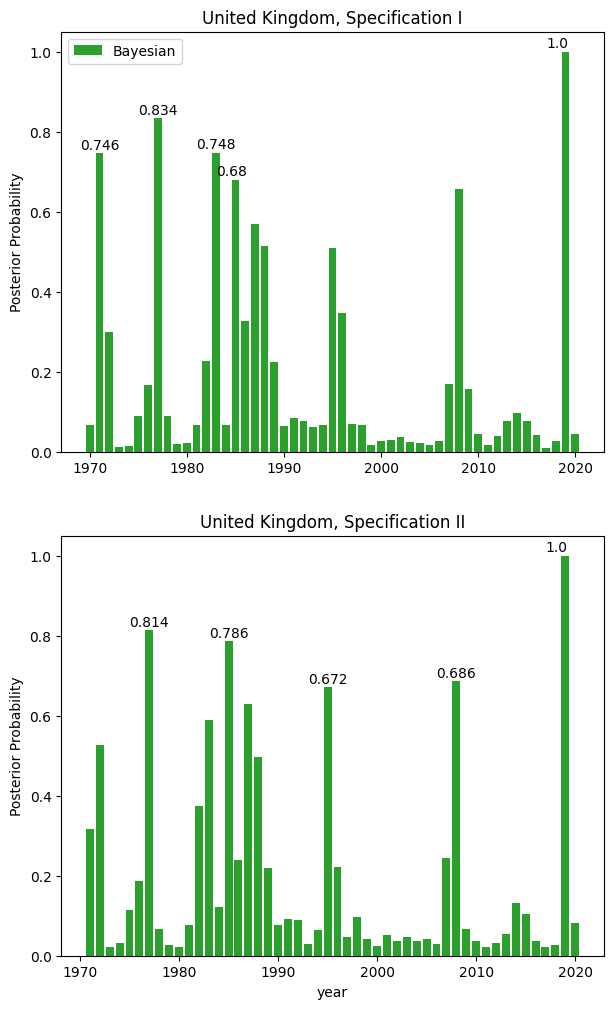

In [ ]:
country_plot = "United Kingdom"
fig, ax = plt.subplots(2, 1, figsize=(7, 12))

ax[0].bar(df_result_spec2_bayes.loc[df_result_spec2_bayes["country"] == country_plot, "year"], df_result_spec2_bayes.loc[df_result_spec2_bayes["country"] == country_plot, "posterior_prob"], color = "tab:green", label = "Bayesian")
ax[1].bar(df_result_spec4_bayes.loc[df_result_spec4_bayes["country"] == country_plot, "year"], df_result_spec4_bayes.loc[df_result_spec4_bayes["country"] == country_plot, "posterior_prob"], color = "tab:green", label = "Bayesian")

year2 = df_result_spec2_bayes.loc[df_result_spec2_bayes["country"] == country_plot,].sort_values("posterior_prob", ascending = False)[["year"]][:5].year.tolist()
prob2 = df_result_spec2_bayes.loc[df_result_spec2_bayes["country"] == country_plot,].sort_values("posterior_prob", ascending = False)[["posterior_prob"]][:5].posterior_prob.tolist()

year4 = df_result_spec4_bayes.loc[df_result_spec4_bayes["country"] == country_plot,].sort_values("posterior_prob", ascending = False)[["year"]][:5].year.tolist()
prob4 = df_result_spec4_bayes.loc[df_result_spec4_bayes["country"] == country_plot,].sort_values("posterior_prob", ascending = False)[["posterior_prob"]][:5].posterior_prob.tolist()

# ax[0].text(year2, prob2, "1")
for i in range(5):
  ax[0].text(year2[i]-2, prob2[i]+0.01, prob2[i])
  ax[1].text(year4[i]-2, prob4[i]+0.01, prob4[i])

ax[0].legend()
ax[0].set_ylabel("Posterior Probability")
ax[1].set_xlabel("year")
ax[1].set_ylabel("Posterior Probability")
ax[0].set_title(country_plot + ", Specification I")
ax[1].set_title(country_plot + ", Specification II")

Text(0.5, 1.0, 'France, Specification II')

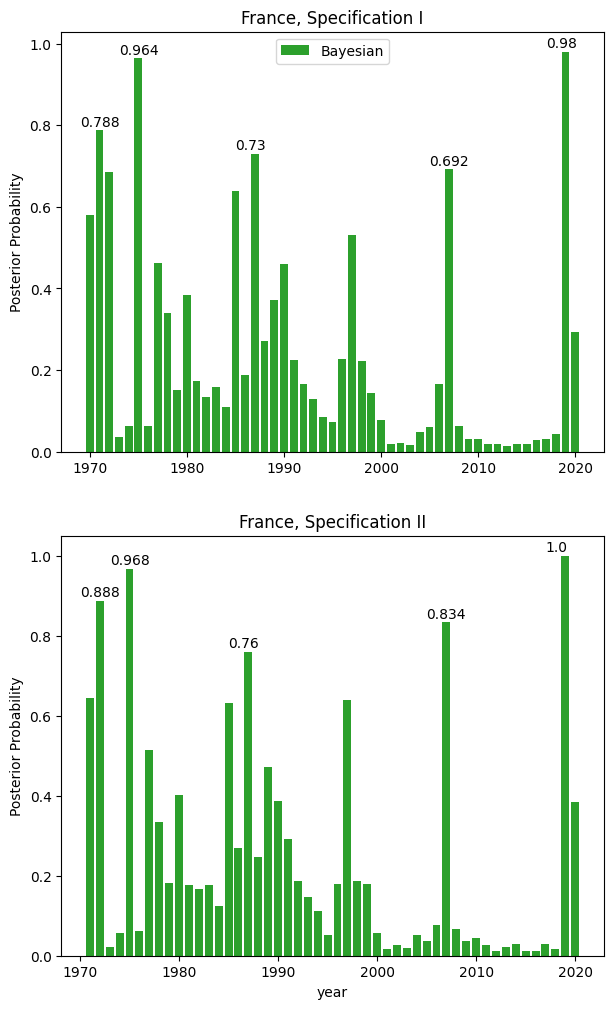

In [ ]:
country_plot = "France"
fig, ax = plt.subplots(2, 1, figsize=(7, 12))

ax[0].bar(df_result_spec2_bayes.loc[df_result_spec2_bayes["country"] == country_plot, "year"], df_result_spec2_bayes.loc[df_result_spec2_bayes["country"] == country_plot, "posterior_prob"], color = "tab:green", label = "Bayesian")
ax[1].bar(df_result_spec4_bayes.loc[df_result_spec4_bayes["country"] == country_plot, "year"], df_result_spec4_bayes.loc[df_result_spec4_bayes["country"] == country_plot, "posterior_prob"], color = "tab:green", label = "Bayesian")

year2 = df_result_spec2_bayes.loc[df_result_spec2_bayes["country"] == country_plot,].sort_values("posterior_prob", ascending = False)[["year"]][:5].year.tolist()
prob2 = df_result_spec2_bayes.loc[df_result_spec2_bayes["country"] == country_plot,].sort_values("posterior_prob", ascending = False)[["posterior_prob"]][:5].posterior_prob.tolist()

year4 = df_result_spec4_bayes.loc[df_result_spec4_bayes["country"] == country_plot,].sort_values("posterior_prob", ascending = False)[["year"]][:5].year.tolist()
prob4 = df_result_spec4_bayes.loc[df_result_spec4_bayes["country"] == country_plot,].sort_values("posterior_prob", ascending = False)[["posterior_prob"]][:5].posterior_prob.tolist()

# ax[0].text(year2, prob2, "1")
for i in range(5):
  ax[0].text(year2[i]-2, prob2[i] + 0.01, prob2[i])
  ax[1].text(year4[i]-2, prob4[i] + 0.01, prob4[i])

ax[0].legend()
ax[0].set_ylabel("Posterior Probability")
ax[1].set_xlabel("year")
ax[1].set_ylabel("Posterior Probability")
ax[0].set_title(country_plot + ", Specification I")
ax[1].set_title(country_plot + ", Specification II")

Text(0.5, 1.0, 'Germany, Specification II')

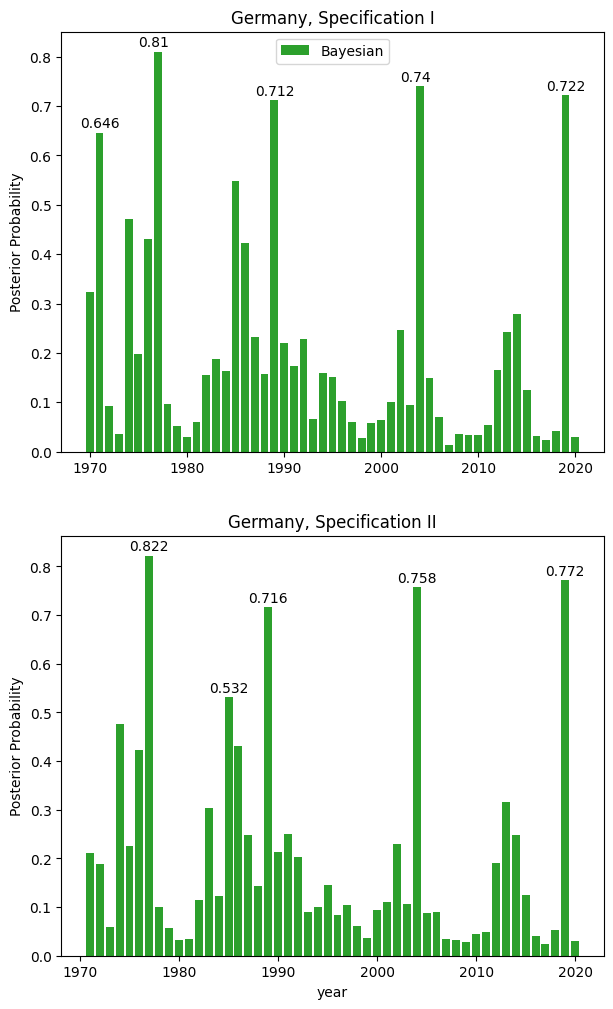

In [ ]:
country_plot = "Germany"
fig, ax = plt.subplots(2, 1, figsize=(7, 12))

ax[0].bar(df_result_spec2_bayes.loc[df_result_spec2_bayes["country"] == country_plot, "year"], df_result_spec2_bayes.loc[df_result_spec2_bayes["country"] == country_plot, "posterior_prob"], color = "tab:green", label = "Bayesian")
ax[1].bar(df_result_spec4_bayes.loc[df_result_spec4_bayes["country"] == country_plot, "year"], df_result_spec4_bayes.loc[df_result_spec4_bayes["country"] == country_plot, "posterior_prob"], color = "tab:green", label = "Bayesian")

year2 = df_result_spec2_bayes.loc[df_result_spec2_bayes["country"] == country_plot,].sort_values("posterior_prob", ascending = False)[["year"]][:5].year.tolist()
prob2 = df_result_spec2_bayes.loc[df_result_spec2_bayes["country"] == country_plot,].sort_values("posterior_prob", ascending = False)[["posterior_prob"]][:5].posterior_prob.tolist()

year4 = df_result_spec4_bayes.loc[df_result_spec4_bayes["country"] == country_plot,].sort_values("posterior_prob", ascending = False)[["year"]][:5].year.tolist()
prob4 = df_result_spec4_bayes.loc[df_result_spec4_bayes["country"] == country_plot,].sort_values("posterior_prob", ascending = False)[["posterior_prob"]][:5].posterior_prob.tolist()

# ax[0].text(year2, prob2, "1")
for i in range(5):
  ax[0].text(year2[i]-2, prob2[i] + 0.01, prob2[i])
  ax[1].text(year4[i]-2, prob4[i] + 0.01, prob4[i])

ax[0].legend()
ax[0].set_ylabel("Posterior Probability")
ax[1].set_xlabel("year")
ax[1].set_ylabel("Posterior Probability")
ax[0].set_title(country_plot + ", Specification I")
ax[1].set_title(country_plot + ", Specification II")

Text(0.5, 1.0, 'Luxembourg, Specification II')

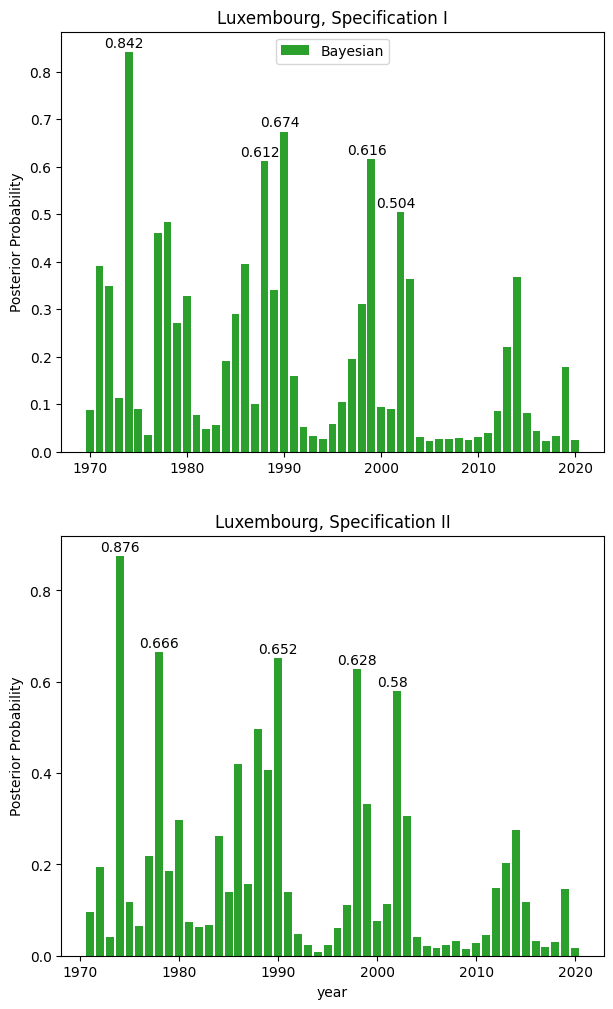

In [ ]:
country_plot = "Luxembourg"
fig, ax = plt.subplots(2, 1, figsize=(7, 12))

ax[0].bar(df_result_spec2_bayes.loc[df_result_spec2_bayes["country"] == country_plot, "year"], df_result_spec2_bayes.loc[df_result_spec2_bayes["country"] == country_plot, "posterior_prob"], color = "tab:green", label = "Bayesian")
ax[1].bar(df_result_spec4_bayes.loc[df_result_spec4_bayes["country"] == country_plot, "year"], df_result_spec4_bayes.loc[df_result_spec4_bayes["country"] == country_plot, "posterior_prob"], color = "tab:green", label = "Bayesian")

year2 = df_result_spec2_bayes.loc[df_result_spec2_bayes["country"] == country_plot,].sort_values("posterior_prob", ascending = False)[["year"]][:5].year.tolist()
prob2 = df_result_spec2_bayes.loc[df_result_spec2_bayes["country"] == country_plot,].sort_values("posterior_prob", ascending = False)[["posterior_prob"]][:5].posterior_prob.tolist()

year4 = df_result_spec4_bayes.loc[df_result_spec4_bayes["country"] == country_plot,].sort_values("posterior_prob", ascending = False)[["year"]][:5].year.tolist()
prob4 = df_result_spec4_bayes.loc[df_result_spec4_bayes["country"] == country_plot,].sort_values("posterior_prob", ascending = False)[["posterior_prob"]][:5].posterior_prob.tolist()

# ax[0].text(year2, prob2, "1")
for i in range(5):
  ax[0].text(year2[i]-2.5, prob2[i] + 0.01, prob2[i])
  ax[1].text(year4[i]-2, prob4[i] + 0.01, prob4[i])

ax[0].legend()
ax[0].set_ylabel("Posterior Probability")
ax[1].set_xlabel("year")
ax[1].set_ylabel("Posterior Probability")
ax[0].set_title(country_plot + ", Specification I")
ax[1].set_title(country_plot + ", Specification II")

Text(0.5, 1.0, 'Ireland, Specification II')

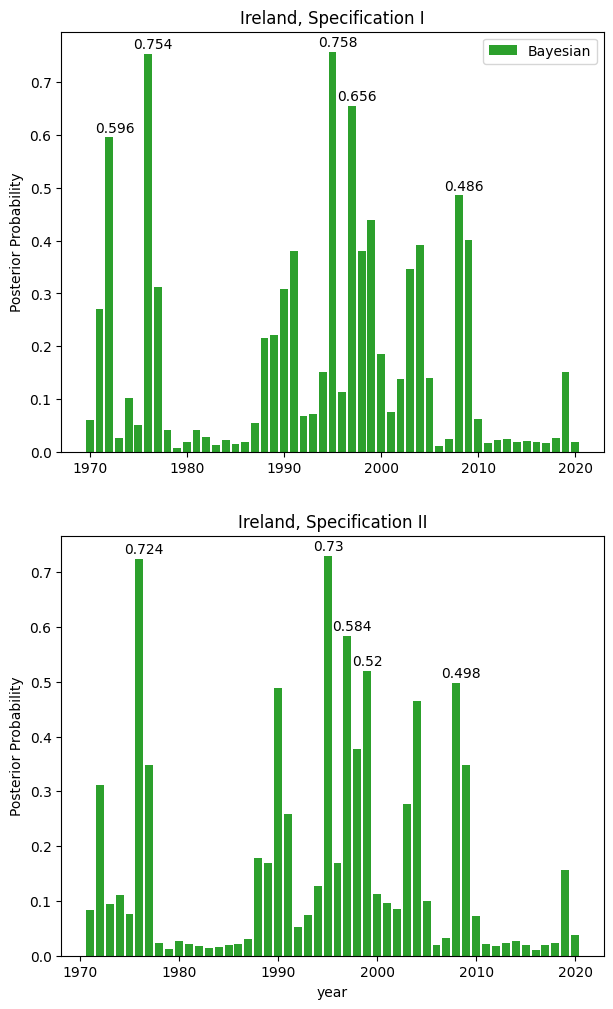

In [ ]:
country_plot = "Ireland"
fig, ax = plt.subplots(2, 1, figsize=(7, 12))

ax[0].bar(df_result_spec2_bayes.loc[df_result_spec2_bayes["country"] == country_plot, "year"], df_result_spec2_bayes.loc[df_result_spec2_bayes["country"] == country_plot, "posterior_prob"], color = "tab:green", label = "Bayesian")
ax[1].bar(df_result_spec4_bayes.loc[df_result_spec4_bayes["country"] == country_plot, "year"], df_result_spec4_bayes.loc[df_result_spec4_bayes["country"] == country_plot, "posterior_prob"], color = "tab:green", label = "Bayesian")

year2 = df_result_spec2_bayes.loc[df_result_spec2_bayes["country"] == country_plot,].sort_values("posterior_prob", ascending = False)[["year"]][:5].year.tolist()
prob2 = df_result_spec2_bayes.loc[df_result_spec2_bayes["country"] == country_plot,].sort_values("posterior_prob", ascending = False)[["posterior_prob"]][:5].posterior_prob.tolist()

year4 = df_result_spec4_bayes.loc[df_result_spec4_bayes["country"] == country_plot,].sort_values("posterior_prob", ascending = False)[["year"]][:5].year.tolist()
prob4 = df_result_spec4_bayes.loc[df_result_spec4_bayes["country"] == country_plot,].sort_values("posterior_prob", ascending = False)[["posterior_prob"]][:5].posterior_prob.tolist()

# ax[0].text(year2, prob2, "1")
for i in range(5):
  ax[0].text(year2[i]-1.5, prob2[i] + 0.01, prob2[i])
  ax[1].text(year4[i]-1.5, prob4[i] + 0.01, prob4[i])

ax[0].legend()
ax[0].set_ylabel("Posterior Probability")
ax[1].set_xlabel("year")
ax[1].set_ylabel("Posterior Probability")
ax[0].set_title(country_plot + ", Specification I")
ax[1].set_title(country_plot + ", Specification II")

Text(0.5, 1.0, 'Malta, Specification II')

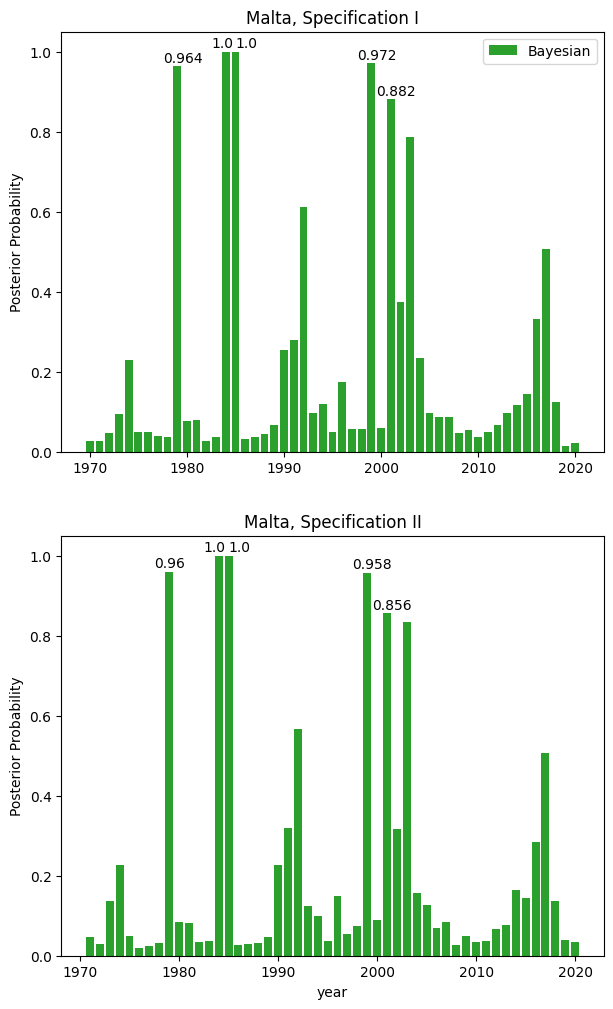

In [ ]:
country_plot = "Malta"
fig, ax = plt.subplots(2, 1, figsize=(7, 12))

ax[0].bar(df_result_spec2_bayes.loc[df_result_spec2_bayes["country"] == country_plot, "year"], df_result_spec2_bayes.loc[df_result_spec2_bayes["country"] == country_plot, "posterior_prob"], color = "tab:green", label = "Bayesian")
ax[1].bar(df_result_spec4_bayes.loc[df_result_spec4_bayes["country"] == country_plot, "year"], df_result_spec4_bayes.loc[df_result_spec4_bayes["country"] == country_plot, "posterior_prob"], color = "tab:green", label = "Bayesian")

year2 = df_result_spec2_bayes.loc[df_result_spec2_bayes["country"] == country_plot,].sort_values("posterior_prob", ascending = False)[["year"]][:5].year.tolist()
prob2 = df_result_spec2_bayes.loc[df_result_spec2_bayes["country"] == country_plot,].sort_values("posterior_prob", ascending = False)[["posterior_prob"]][:5].posterior_prob.tolist()

year4 = df_result_spec4_bayes.loc[df_result_spec4_bayes["country"] == country_plot,].sort_values("posterior_prob", ascending = False)[["year"]][:5].year.tolist()
prob4 = df_result_spec4_bayes.loc[df_result_spec4_bayes["country"] == country_plot,].sort_values("posterior_prob", ascending = False)[["posterior_prob"]][:5].posterior_prob.tolist()

# ax[0].text(year2, prob2, "1")
for i in range(5):
  if i == 1:
    ax[0].text(year2[i]+1, prob2[i] + 0.01, prob2[i])
    ax[1].text(year4[i], prob4[i] + 0.01, prob4[i])
  elif i == 0:
    ax[0].text(year2[i]-2.5, prob2[i] + 0.01, prob2[i])
    ax[1].text(year4[i]-1.5, prob4[i] + 0.01, prob4[i])
  else:
    ax[0].text(year2[i]-1.5, prob2[i] + 0.01, prob2[i])
    ax[1].text(year4[i]-1.5, prob4[i] + 0.01, prob4[i])

ax[0].legend(loc = "upper right")
ax[0].set_ylabel("Posterior Probability")
ax[1].set_xlabel("year")
ax[1].set_ylabel("Posterior Probability")
ax[0].set_title(country_plot + ", Specification I")
ax[1].set_title(country_plot + ", Specification II")

## 2 panels

Text(0.5, 1.0, 'United Kingdom, Specification II')

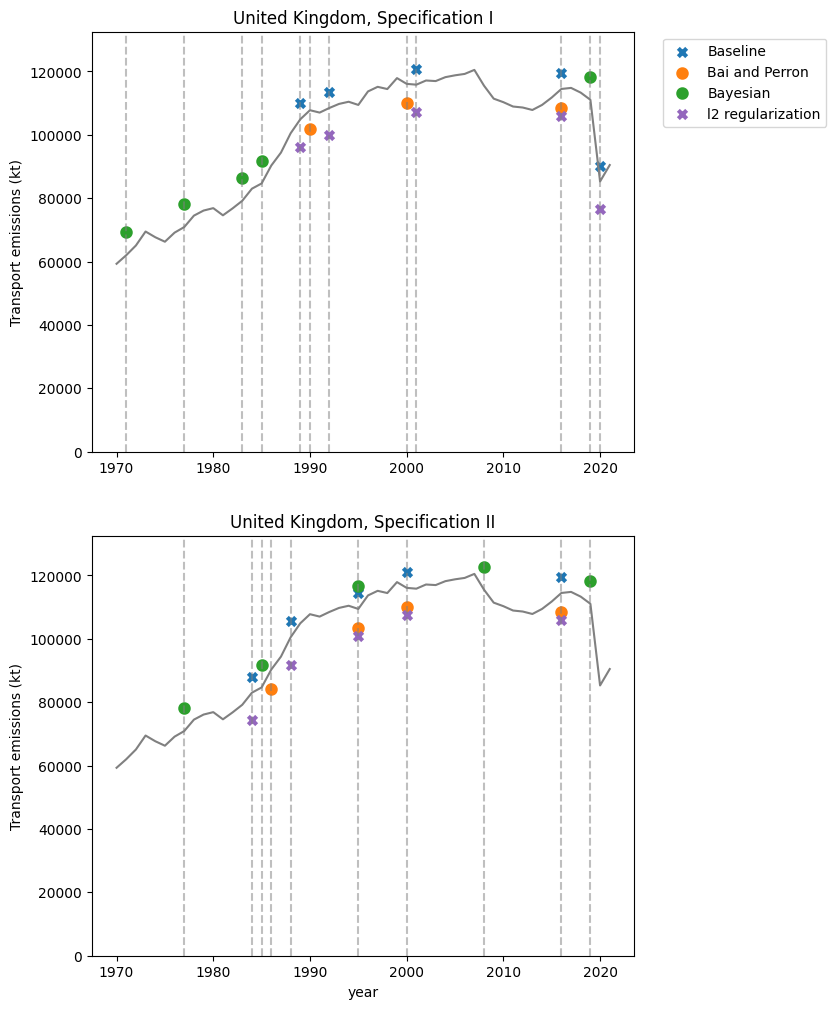

In [ ]:
country_plot = "United Kingdom"

fig, ax = plt.subplots(2, 1, figsize=(7, 12))

ax[0].plot(df.loc[df["country"] == country_plot, "year"], df.loc[df["country"] == country_plot, "transport.emissions"], color = "gray")
ax[1].plot(df.loc[df["country"] == country_plot, "year"], df.loc[df["country"] == country_plot, "transport.emissions"], color = "gray")

store_year_change_point_2 = []
store_year_change_point_4 = []

methods = ['Baseline', 'Bai and Perron', 'Bayesian', 'l2 regularization']

color_list = ["tab:blue", "tab:orange", "tab:green", "tab:purple"]

for i in range(len(methods)):
  item = methods[i]

  if item == 'Bayesian':
    year_change_point_2 = df_result_spec2_bayes.sort_values("posterior_prob", ascending = False).loc[(df_result_spec2_bayes["country"] == country_plot), "year"].tolist()[:5]
    year_change_point_4 = df_result_spec4_bayes.sort_values("posterior_prob", ascending = False).loc[(df_result_spec4_bayes["country"] == country_plot), "year"].tolist()[:5]

    year_change_point_2.sort()
    year_change_point_4.sort()

    corresponding_emission_2 = df.loc[(df["country"] == country_plot) & (df["year"].isin(map(float, year_change_point_2))) , "transport.emissions"]
    corresponding_emission_4 = df.loc[(df["country"] == country_plot) & (df["year"].isin(map(float, year_change_point_4))) , "transport.emissions"]

  else:
    year_change_point_2 = df_result_spec2_all.loc[(df_result_spec2_all["country"] == country_plot) & (df_result_spec2_all["method"] == item), "optimal_change_point_year"].tolist()[0]
    year_change_point_4 = df_result_spec4_all.loc[(df_result_spec4_all["country"] == country_plot) & (df_result_spec4_all["method"] == item), "optimal_change_point_year"].tolist()[0]

    corresponding_emission_2 = df.loc[(df["country"] == country_plot) & (df["year"].isin(map(float, year_change_point_2))) , "transport.emissions"]
    corresponding_emission_4 = df.loc[(df["country"] == country_plot) & (df["year"].isin(map(float, year_change_point_4))) , "transport.emissions"]

  corresponding_emission_2 = corresponding_emission_2 + (5000*((-1.2)**(i)))
  corresponding_emission_4 = corresponding_emission_4 + (5000*((-1.2)**(i)))

  if (item == "Bai and Perron") | (item == 'Bayesian'):
    ax[0].scatter(year_change_point_2, corresponding_emission_2, marker = "o", linewidths = 3, label = item, color = color_list[i])
    ax[1].scatter(year_change_point_4, corresponding_emission_4, marker = "o", linewidths = 3, label = item, color = color_list[i])
  else:
    ax[0].scatter(year_change_point_2, corresponding_emission_2, marker = "x", linewidths = 3, label = item, color = color_list[i])
    ax[1].scatter(year_change_point_4, corresponding_emission_4, marker = "x", linewidths = 3, label = item, color = color_list[i])

  store_year_change_point_2 = store_year_change_point_2 + year_change_point_2
  store_year_change_point_4 = store_year_change_point_4 + year_change_point_4

for j in np.unique(np.array(store_year_change_point_2)):
  ax[0].axvline(x = j, color = "gray", linestyle = "--", alpha = .5)

for j in np.unique(np.array(store_year_change_point_4)):
  ax[1].axvline(x = j, color = "gray", linestyle = "--", alpha = .5)

ax[0].set_ylim((0,df.loc[df["country"] == country_plot, "transport.emissions"].max()*1.1))
ax[1].set_ylim((0,df.loc[df["country"] == country_plot, "transport.emissions"].max()*1.1))

ax[0].legend(bbox_to_anchor=(1.04, 1), loc="upper left")
#ax[0].set_xlabel("year")
ax[0].set_ylabel("Transport emissions (kt)")
ax[1].set_xlabel("year")
ax[1].set_ylabel("Transport emissions (kt)")
ax[0].set_title(country_plot + ", Specification I")
ax[1].set_title( country_plot + ", Specification II")

Text(0.5, 1.0, 'France, Specification II')

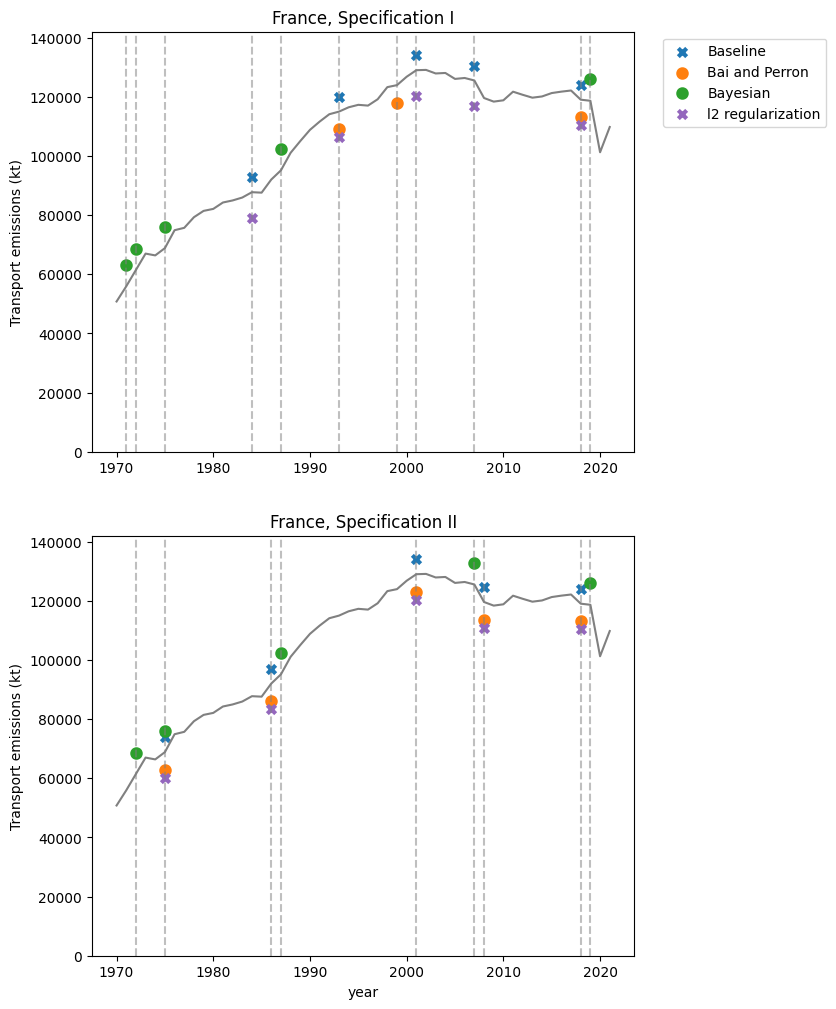

In [ ]:
country_plot = "France"

fig, ax = plt.subplots(2, 1, figsize=(7, 12))

ax[0].plot(df.loc[df["country"] == country_plot, "year"], df.loc[df["country"] == country_plot, "transport.emissions"], color = "gray")
ax[1].plot(df.loc[df["country"] == country_plot, "year"], df.loc[df["country"] == country_plot, "transport.emissions"], color = "gray")

store_year_change_point_2 = []
store_year_change_point_4 = []

methods = ['Baseline', 'Bai and Perron', 'Bayesian', 'l2 regularization']

color_list = ["tab:blue", "tab:orange", "tab:green", "tab:purple"]

for i in range(len(methods)):
  item = methods[i]

  if item == 'Bayesian':
    year_change_point_2 = df_result_spec2_bayes.sort_values("posterior_prob", ascending = False).loc[(df_result_spec2_bayes["country"] == country_plot), "year"].tolist()[:5]
    year_change_point_4 = df_result_spec4_bayes.sort_values("posterior_prob", ascending = False).loc[(df_result_spec4_bayes["country"] == country_plot), "year"].tolist()[:5]

    year_change_point_2.sort()
    year_change_point_4.sort()

  else:
    year_change_point_2 = df_result_spec2_all.loc[(df_result_spec2_all["country"] == country_plot) & (df_result_spec2_all["method"] == item), "optimal_change_point_year"].tolist()[0]
    year_change_point_4 = df_result_spec4_all.loc[(df_result_spec4_all["country"] == country_plot) & (df_result_spec4_all["method"] == item), "optimal_change_point_year"].tolist()[0]

  corresponding_emission_2 = df.loc[(df["country"] == country_plot) & (df["year"].isin(map(float, year_change_point_2))) , "transport.emissions"]
  corresponding_emission_4 = df.loc[(df["country"] == country_plot) & (df["year"].isin(map(float, year_change_point_4))) , "transport.emissions"]

  corresponding_emission_2 = corresponding_emission_2 + (5000*((-1.2)**(i)))
  corresponding_emission_4 = corresponding_emission_4 + (5000*((-1.2)**(i)))

  if (item == "Bai and Perron") | (item == 'Bayesian'):
    ax[0].scatter(year_change_point_2, corresponding_emission_2, marker = "o", linewidths = 3, label = item, color = color_list[i])
    ax[1].scatter(year_change_point_4, corresponding_emission_4, marker = "o", linewidths = 3, label = item, color = color_list[i])
  else:
    ax[0].scatter(year_change_point_2, corresponding_emission_2, marker = "x", linewidths = 3, label = item, color = color_list[i])
    ax[1].scatter(year_change_point_4, corresponding_emission_4, marker = "x", linewidths = 3, label = item, color = color_list[i])

  store_year_change_point_2 = store_year_change_point_2 + year_change_point_2
  store_year_change_point_4 = store_year_change_point_4 + year_change_point_4

for j in np.unique(np.array(store_year_change_point_2)):
  ax[0].axvline(x = j, color = "gray", linestyle = "--", alpha = .5)

for j in np.unique(np.array(store_year_change_point_4)):
  ax[1].axvline(x = j, color = "gray", linestyle = "--", alpha = .5)

ax[0].set_ylim((0,df.loc[df["country"] == country_plot, "transport.emissions"].max()*1.1))
ax[1].set_ylim((0,df.loc[df["country"] == country_plot, "transport.emissions"].max()*1.1))

ax[0].legend(bbox_to_anchor=(1.04, 1), loc="upper left")
#ax[0].set_xlabel("year")
ax[0].set_ylabel("Transport emissions (kt)")
ax[1].set_xlabel("year")
ax[1].set_ylabel("Transport emissions (kt)")
ax[0].set_title(country_plot + ", Specification I")
ax[1].set_title( country_plot + ", Specification II")

Text(0.5, 1.0, 'Germany, Specification II')

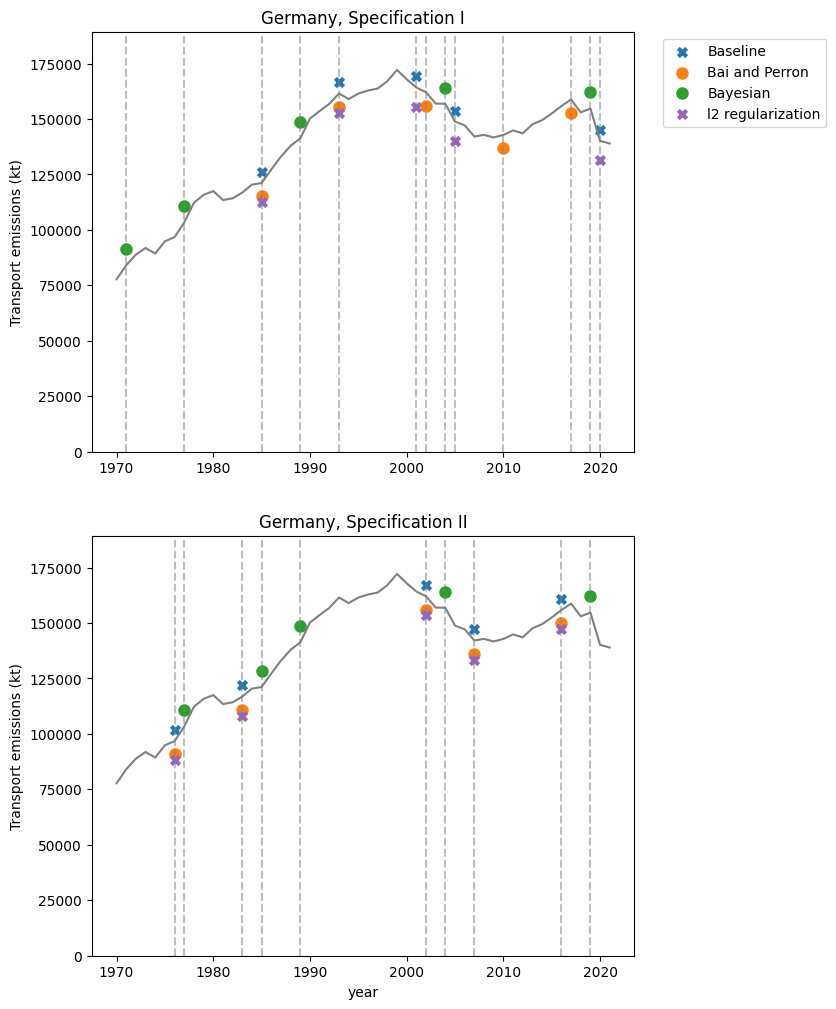

In [ ]:
country_plot = "Germany"

fig, ax = plt.subplots(2, 1, figsize=(7, 12))

ax[0].plot(df.loc[df["country"] == country_plot, "year"], df.loc[df["country"] == country_plot, "transport.emissions"], color = "gray")
ax[1].plot(df.loc[df["country"] == country_plot, "year"], df.loc[df["country"] == country_plot, "transport.emissions"], color = "gray")

store_year_change_point_2 = []
store_year_change_point_4 = []

methods = ['Baseline', 'Bai and Perron', 'Bayesian', 'l2 regularization']

color_list = ["tab:blue", "tab:orange", "tab:green", "tab:purple"]

for i in range(len(methods)):
  item = methods[i]

  if item == 'Bayesian':
    year_change_point_2 = df_result_spec2_bayes.sort_values("posterior_prob", ascending = False).loc[(df_result_spec2_bayes["country"] == country_plot), "year"].tolist()[:5]
    year_change_point_4 = df_result_spec4_bayes.sort_values("posterior_prob", ascending = False).loc[(df_result_spec4_bayes["country"] == country_plot), "year"].tolist()[:5]

    year_change_point_2.sort()
    year_change_point_4.sort()

  else:
    year_change_point_2 = df_result_spec2_all.loc[(df_result_spec2_all["country"] == country_plot) & (df_result_spec2_all["method"] == item), "optimal_change_point_year"].tolist()[0]
    year_change_point_4 = df_result_spec4_all.loc[(df_result_spec4_all["country"] == country_plot) & (df_result_spec4_all["method"] == item), "optimal_change_point_year"].tolist()[0]

  corresponding_emission_2 = df.loc[(df["country"] == country_plot) & (df["year"].isin(map(float, year_change_point_2))) , "transport.emissions"]
  corresponding_emission_4 = df.loc[(df["country"] == country_plot) & (df["year"].isin(map(float, year_change_point_4))) , "transport.emissions"]

  corresponding_emission_2 = corresponding_emission_2 + (5000*((-1.2)**(i)))
  corresponding_emission_4 = corresponding_emission_4 + (5000*((-1.2)**(i)))

  if (item == "Bai and Perron") | (item == 'Bayesian'):
    ax[0].scatter(year_change_point_2, corresponding_emission_2, marker = "o", linewidths = 3, label = item, color = color_list[i])
    ax[1].scatter(year_change_point_4, corresponding_emission_4, marker = "o", linewidths = 3, label = item, color = color_list[i])
  else:
    ax[0].scatter(year_change_point_2, corresponding_emission_2, marker = "x", linewidths = 3, label = item, color = color_list[i])
    ax[1].scatter(year_change_point_4, corresponding_emission_4, marker = "x", linewidths = 3, label = item, color = color_list[i])

  store_year_change_point_2 = store_year_change_point_2 + year_change_point_2
  store_year_change_point_4 = store_year_change_point_4 + year_change_point_4

for j in np.unique(np.array(store_year_change_point_2)):
  ax[0].axvline(x = j, color = "gray", linestyle = "--", alpha = .5)

for j in np.unique(np.array(store_year_change_point_4)):
  ax[1].axvline(x = j, color = "gray", linestyle = "--", alpha = .5)

ax[0].set_ylim((0,df.loc[df["country"] == country_plot, "transport.emissions"].max()*1.1))
ax[1].set_ylim((0,df.loc[df["country"] == country_plot, "transport.emissions"].max()*1.1))

ax[0].legend(bbox_to_anchor=(1.04, 1), loc="upper left")
#ax[0].set_xlabel("year")
ax[0].set_ylabel("Transport emissions (kt)")
ax[1].set_xlabel("year")
ax[1].set_ylabel("Transport emissions (kt)")
ax[0].set_title(country_plot + ", Specification I")
ax[1].set_title( country_plot + ", Specification II")

Text(0.5, 1.0, 'Luxembourg, Specification II')

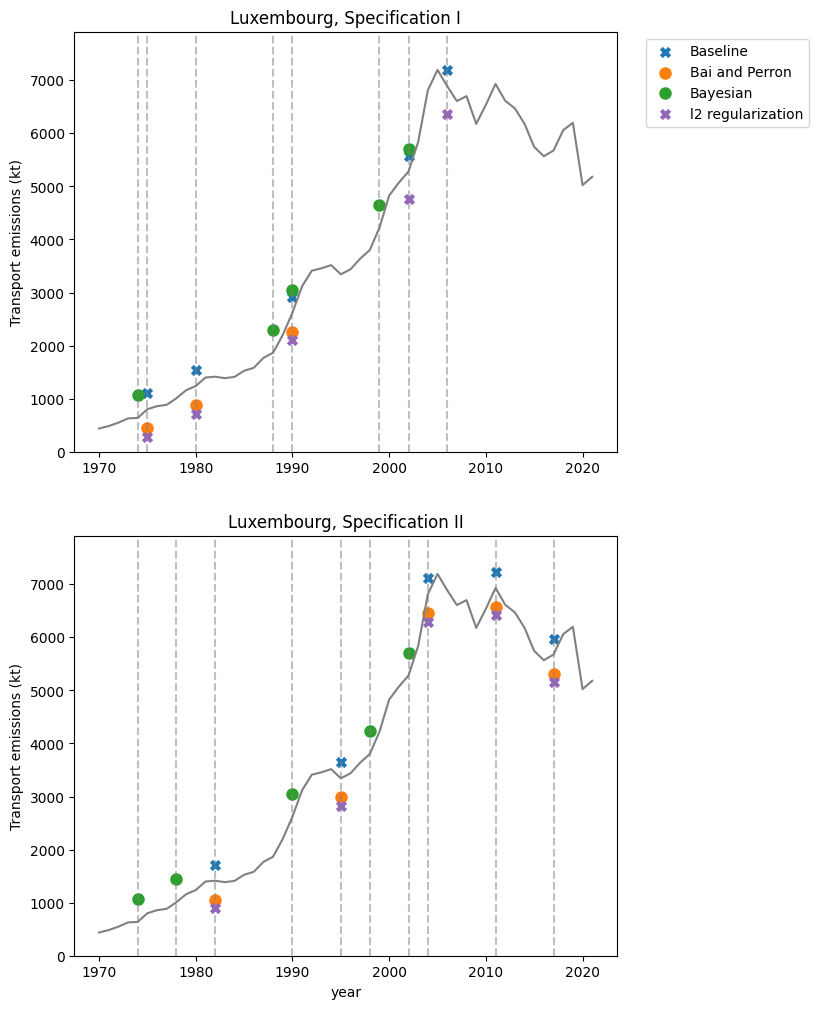

In [ ]:
country_plot = "Luxembourg"

fig, ax = plt.subplots(2, 1, figsize=(7, 12))

ax[0].plot(df.loc[df["country"] == country_plot, "year"], df.loc[df["country"] == country_plot, "transport.emissions"], color = "gray")
ax[1].plot(df.loc[df["country"] == country_plot, "year"], df.loc[df["country"] == country_plot, "transport.emissions"], color = "gray")

store_year_change_point_2 = []
store_year_change_point_4 = []

methods = ['Baseline', 'Bai and Perron', 'Bayesian', 'l2 regularization']

color_list = ["tab:blue", "tab:orange", "tab:green", "tab:purple"]

for i in range(len(methods)):
  item = methods[i]

  if item == 'Bayesian':
    year_change_point_2 = df_result_spec2_bayes.sort_values("posterior_prob", ascending = False).loc[(df_result_spec2_bayes["country"] == country_plot), "year"].tolist()[:5]
    year_change_point_4 = df_result_spec4_bayes.sort_values("posterior_prob", ascending = False).loc[(df_result_spec4_bayes["country"] == country_plot), "year"].tolist()[:5]

    year_change_point_2.sort()
    year_change_point_4.sort()

  else:
    year_change_point_2 = df_result_spec2_all.loc[(df_result_spec2_all["country"] == country_plot) & (df_result_spec2_all["method"] == item), "optimal_change_point_year"].tolist()[0]
    year_change_point_4 = df_result_spec4_all.loc[(df_result_spec4_all["country"] == country_plot) & (df_result_spec4_all["method"] == item), "optimal_change_point_year"].tolist()[0]

  corresponding_emission_2 = df.loc[(df["country"] == country_plot) & (df["year"].isin(map(float, year_change_point_2))) , "transport.emissions"]
  corresponding_emission_4 = df.loc[(df["country"] == country_plot) & (df["year"].isin(map(float, year_change_point_4))) , "transport.emissions"]

  corresponding_emission_2 = corresponding_emission_2 + (300*((-1.2)**(i)))
  corresponding_emission_4 = corresponding_emission_4 + (300*((-1.2)**(i)))

  if (item == "Bai and Perron") | (item == 'Bayesian'):
    ax[0].scatter(year_change_point_2, corresponding_emission_2, marker = "o", linewidths = 3, label = item, color = color_list[i])
    ax[1].scatter(year_change_point_4, corresponding_emission_4, marker = "o", linewidths = 3, label = item, color = color_list[i])
  else:
    ax[0].scatter(year_change_point_2, corresponding_emission_2, marker = "x", linewidths = 3, label = item, color = color_list[i])
    ax[1].scatter(year_change_point_4, corresponding_emission_4, marker = "x", linewidths = 3, label = item, color = color_list[i])

  store_year_change_point_2 = store_year_change_point_2 + year_change_point_2
  store_year_change_point_4 = store_year_change_point_4 + year_change_point_4

for j in np.unique(np.array(store_year_change_point_2)):
  ax[0].axvline(x = j, color = "gray", linestyle = "--", alpha = .5)

for j in np.unique(np.array(store_year_change_point_4)):
  ax[1].axvline(x = j, color = "gray", linestyle = "--", alpha = .5)

ax[0].set_ylim((0,df.loc[df["country"] == country_plot, "transport.emissions"].max()*1.1))
ax[1].set_ylim((0,df.loc[df["country"] == country_plot, "transport.emissions"].max()*1.1))

ax[0].legend(bbox_to_anchor=(1.04, 1), loc="upper left")
#ax[0].set_xlabel("year")
ax[0].set_ylabel("Transport emissions (kt)")
ax[1].set_xlabel("year")
ax[1].set_ylabel("Transport emissions (kt)")
ax[0].set_title(country_plot + ", Specification I")
ax[1].set_title( country_plot + ", Specification II")

Text(0.5, 1.0, 'Ireland, Specification II')

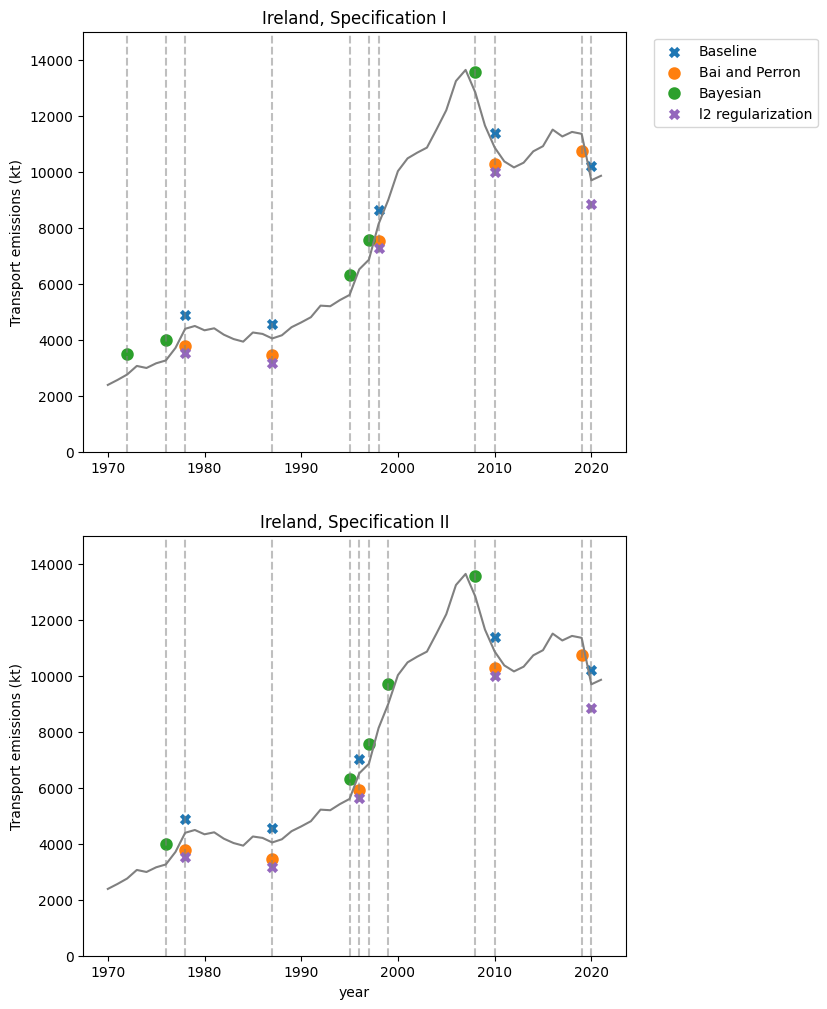

In [ ]:
country_plot = "Ireland"

fig, ax = plt.subplots(2, 1, figsize=(7, 12))

ax[0].plot(df.loc[df["country"] == country_plot, "year"], df.loc[df["country"] == country_plot, "transport.emissions"], color = "gray")
ax[1].plot(df.loc[df["country"] == country_plot, "year"], df.loc[df["country"] == country_plot, "transport.emissions"], color = "gray")

store_year_change_point_2 = []
store_year_change_point_4 = []

methods = ['Baseline', 'Bai and Perron', 'Bayesian', 'l2 regularization']

color_list = ["tab:blue", "tab:orange", "tab:green", "tab:purple"]

for i in range(len(methods)):
  item = methods[i]

  if item == 'Bayesian':
    year_change_point_2 = df_result_spec2_bayes.sort_values("posterior_prob", ascending = False).loc[(df_result_spec2_bayes["country"] == country_plot), "year"].tolist()[:5]
    year_change_point_4 = df_result_spec4_bayes.sort_values("posterior_prob", ascending = False).loc[(df_result_spec4_bayes["country"] == country_plot), "year"].tolist()[:5]

    year_change_point_2.sort()
    year_change_point_4.sort()

  else:
    year_change_point_2 = df_result_spec2_all.loc[(df_result_spec2_all["country"] == country_plot) & (df_result_spec2_all["method"] == item), "optimal_change_point_year"].tolist()[0]
    year_change_point_4 = df_result_spec4_all.loc[(df_result_spec4_all["country"] == country_plot) & (df_result_spec4_all["method"] == item), "optimal_change_point_year"].tolist()[0]

  corresponding_emission_2 = df.loc[(df["country"] == country_plot) & (df["year"].isin(map(float, year_change_point_2))) , "transport.emissions"]
  corresponding_emission_4 = df.loc[(df["country"] == country_plot) & (df["year"].isin(map(float, year_change_point_4))) , "transport.emissions"]

  corresponding_emission_2 = corresponding_emission_2 + (500*((-1.2)**(i)))
  corresponding_emission_4 = corresponding_emission_4 + (500*((-1.2)**(i)))

  if (item == "Bai and Perron") | (item == 'Bayesian'):
    ax[0].scatter(year_change_point_2, corresponding_emission_2, marker = "o", linewidths = 3, label = item, color = color_list[i])
    ax[1].scatter(year_change_point_4, corresponding_emission_4, marker = "o", linewidths = 3, label = item, color = color_list[i])
  else:
    ax[0].scatter(year_change_point_2, corresponding_emission_2, marker = "x", linewidths = 3, label = item, color = color_list[i])
    ax[1].scatter(year_change_point_4, corresponding_emission_4, marker = "x", linewidths = 3, label = item, color = color_list[i])

  store_year_change_point_2 = store_year_change_point_2 + year_change_point_2
  store_year_change_point_4 = store_year_change_point_4 + year_change_point_4

for j in np.unique(np.array(store_year_change_point_2)):
  ax[0].axvline(x = j, color = "gray", linestyle = "--", alpha = .5)

for j in np.unique(np.array(store_year_change_point_4)):
  ax[1].axvline(x = j, color = "gray", linestyle = "--", alpha = .5)

ax[0].set_ylim((0,df.loc[df["country"] == country_plot, "transport.emissions"].max()*1.1))
ax[1].set_ylim((0,df.loc[df["country"] == country_plot, "transport.emissions"].max()*1.1))

ax[0].legend(bbox_to_anchor=(1.04, 1), loc="upper left")
#ax[0].set_xlabel("year")
ax[0].set_ylabel("Transport emissions (kt)")
ax[1].set_xlabel("year")
ax[1].set_ylabel("Transport emissions (kt)")
ax[0].set_title(country_plot + ", Specification I")
ax[1].set_title( country_plot + ", Specification II")

Text(0.5, 1.0, 'Malta, Specification II')

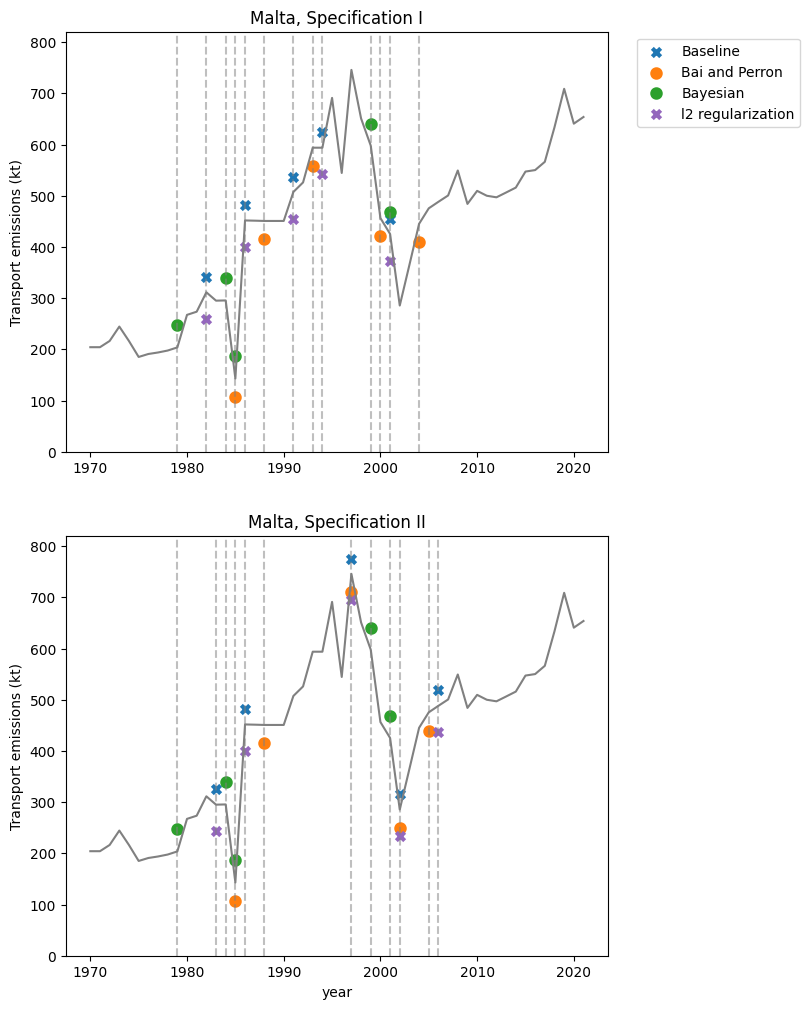

In [ ]:
country_plot = "Malta"

fig, ax = plt.subplots(2, 1, figsize=(7, 12))

ax[0].plot(df.loc[df["country"] == country_plot, "year"], df.loc[df["country"] == country_plot, "transport.emissions"], color = "gray")
ax[1].plot(df.loc[df["country"] == country_plot, "year"], df.loc[df["country"] == country_plot, "transport.emissions"], color = "gray")

store_year_change_point_2 = []
store_year_change_point_4 = []

methods = ['Baseline', 'Bai and Perron', 'Bayesian', 'l2 regularization']

color_list = ["tab:blue", "tab:orange", "tab:green", "tab:purple"]

for i in range(len(methods)):
  item = methods[i]

  if item == 'Bayesian':
    year_change_point_2 = df_result_spec2_bayes.sort_values("posterior_prob", ascending = False).loc[(df_result_spec2_bayes["country"] == country_plot), "year"].tolist()[:5]
    year_change_point_4 = df_result_spec4_bayes.sort_values("posterior_prob", ascending = False).loc[(df_result_spec4_bayes["country"] == country_plot), "year"].tolist()[:5]

    year_change_point_2.sort()
    year_change_point_4.sort()

  else:
    year_change_point_2 = df_result_spec2_all.loc[(df_result_spec2_all["country"] == country_plot) & (df_result_spec2_all["method"] == item), "optimal_change_point_year"].tolist()[0]
    year_change_point_4 = df_result_spec4_all.loc[(df_result_spec4_all["country"] == country_plot) & (df_result_spec4_all["method"] == item), "optimal_change_point_year"].tolist()[0]

  corresponding_emission_2 = df.loc[(df["country"] == country_plot) & (df["year"].isin(map(float, year_change_point_2))) , "transport.emissions"]
  corresponding_emission_4 = df.loc[(df["country"] == country_plot) & (df["year"].isin(map(float, year_change_point_4))) , "transport.emissions"]

  corresponding_emission_2 = corresponding_emission_2 + (30*((-1.2)**(i)))
  corresponding_emission_4 = corresponding_emission_4 + (30*((-1.2)**(i)))

  if (item == "Bai and Perron") | (item == 'Bayesian'):
    ax[0].scatter(year_change_point_2, corresponding_emission_2, marker = "o", linewidths = 3, label = item, color = color_list[i])
    ax[1].scatter(year_change_point_4, corresponding_emission_4, marker = "o", linewidths = 3, label = item, color = color_list[i])
  else:
    ax[0].scatter(year_change_point_2, corresponding_emission_2, marker = "x", linewidths = 3, label = item, color = color_list[i])
    ax[1].scatter(year_change_point_4, corresponding_emission_4, marker = "x", linewidths = 3, label = item, color = color_list[i])

  store_year_change_point_2 = store_year_change_point_2 + year_change_point_2
  store_year_change_point_4 = store_year_change_point_4 + year_change_point_4

for j in np.unique(np.array(store_year_change_point_2)):
  ax[0].axvline(x = j, color = "gray", linestyle = "--", alpha = .5)

for j in np.unique(np.array(store_year_change_point_4)):
  ax[1].axvline(x = j, color = "gray", linestyle = "--", alpha = .5)

ax[0].set_ylim((0,df.loc[df["country"] == country_plot, "transport.emissions"].max()*1.1))
ax[1].set_ylim((0,df.loc[df["country"] == country_plot, "transport.emissions"].max()*1.1))

ax[0].legend(bbox_to_anchor=(1.04, 1), loc="upper left")
#ax[0].set_xlabel("year")
ax[0].set_ylabel("Transport emissions (kt)")
ax[1].set_xlabel("year")
ax[1].set_ylabel("Transport emissions (kt)")
ax[0].set_title(country_plot + ", Specification I")
ax[1].set_title( country_plot + ", Specification II")

## 4 Panles

Text(0.5, 1.0, 'United Kingdom, Specification II')

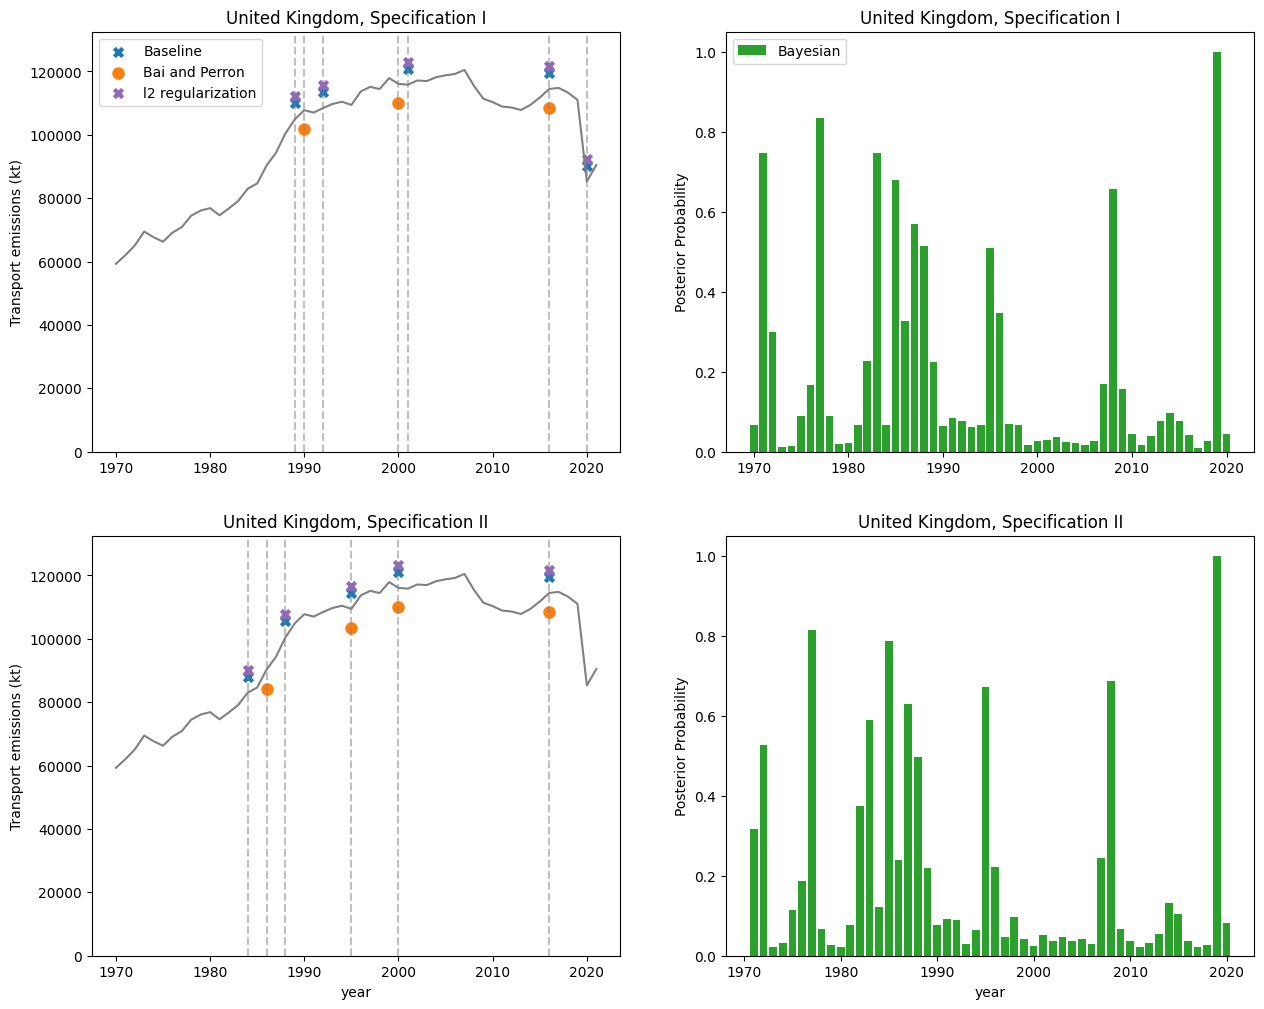

In [ ]:
country_plot = "United Kingdom"

fig, ax = plt.subplots(2, 2, figsize=(15, 12))

ax[0, 0].plot(df.loc[df["country"] == country_plot, "year"], df.loc[df["country"] == country_plot, "transport.emissions"], color = "gray")
ax[1, 0].plot(df.loc[df["country"] == country_plot, "year"], df.loc[df["country"] == country_plot, "transport.emissions"], color = "gray")

store_year_change_point_2 = []
store_year_change_point_4 = []

methods = ['Baseline', 'Bai and Perron', 'l2 regularization']

color_list = ["tab:blue", "tab:orange", "tab:purple"] # "tab:green" for bayesian

for i in range(len(methods)):
  item = methods[i]

  year_change_point_2 = df_result_spec2_all.loc[(df_result_spec2_all["country"] == country_plot) & (df_result_spec2_all["method"] == item), "optimal_change_point_year"].tolist()[0]
  year_change_point_4 = df_result_spec4_all.loc[(df_result_spec4_all["country"] == country_plot) & (df_result_spec4_all["method"] == item), "optimal_change_point_year"].tolist()[0]

  corresponding_emission_2 = df.loc[(df["country"] == country_plot) & (df["year"].isin(map(float, year_change_point_2))) , "transport.emissions"]
  corresponding_emission_4 = df.loc[(df["country"] == country_plot) & (df["year"].isin(map(float, year_change_point_4))) , "transport.emissions"]

  corresponding_emission_2 = corresponding_emission_2 + (5000*((-1.2)**(i)))
  corresponding_emission_4 = corresponding_emission_4 + (5000*((-1.2)**(i)))

  if (item == "Bai and Perron"):
    ax[0, 0].scatter(year_change_point_2, corresponding_emission_2, marker = "o", linewidths = 3, label = item, color = color_list[i])
    ax[1, 0].scatter(year_change_point_4, corresponding_emission_4, marker = "o", linewidths = 3, label = item, color = color_list[i])
  else:
    ax[0, 0].scatter(year_change_point_2, corresponding_emission_2, marker = "x", linewidths = 3, label = item, color = color_list[i])
    ax[1, 0].scatter(year_change_point_4, corresponding_emission_4, marker = "x", linewidths = 3, label = item, color = color_list[i])
  store_year_change_point_2 = store_year_change_point_2 + year_change_point_2
  store_year_change_point_4 = store_year_change_point_4 + year_change_point_4

for j in np.unique(np.array(store_year_change_point_2)):
  ax[0, 0].axvline(x = j, color = "gray", linestyle = "--", alpha = .5)

for j in np.unique(np.array(store_year_change_point_4)):
  ax[1, 0].axvline(x = j, color = "gray", linestyle = "--", alpha = .5)

ax[0, 0].set_ylim((0,df.loc[df["country"] == country_plot, "transport.emissions"].max()*1.1))
ax[1, 0].set_ylim((0,df.loc[df["country"] == country_plot, "transport.emissions"].max()*1.1))

ax[0, 0].legend()
#ax[0].set_xlabel("year")
ax[0, 0].set_ylabel("Transport emissions (kt)")
ax[1, 0].set_xlabel("year")
ax[1, 0].set_ylabel("Transport emissions (kt)")
ax[0, 0].set_title(country_plot + ", Specification I")
ax[1, 0].set_title(country_plot + ", Specification II")

ax[0, 1].bar(df_result_spec2_bayes.loc[df_result_spec2_bayes["country"] == country_plot, "year"], df_result_spec2_bayes.loc[df_result_spec2_bayes["country"] == country_plot, "posterior_prob"], color = "tab:green", label = "Bayesian")
ax[1, 1].bar(df_result_spec4_bayes.loc[df_result_spec4_bayes["country"] == country_plot, "year"], df_result_spec4_bayes.loc[df_result_spec4_bayes["country"] == country_plot, "posterior_prob"], color = "tab:green", label = "Bayesian")

ax[0, 1].legend()
ax[0, 1].set_ylabel("Posterior Probability")
ax[1, 1].set_xlabel("year")
ax[1, 1].set_ylabel("Posterior Probability")
ax[0, 1].set_title(country_plot + ", Specification I")
ax[1, 1].set_title(country_plot + ", Specification II")

## GDP, POP

In [ ]:
country_6[0:3]

['United Kingdom', 'France', 'Germany']

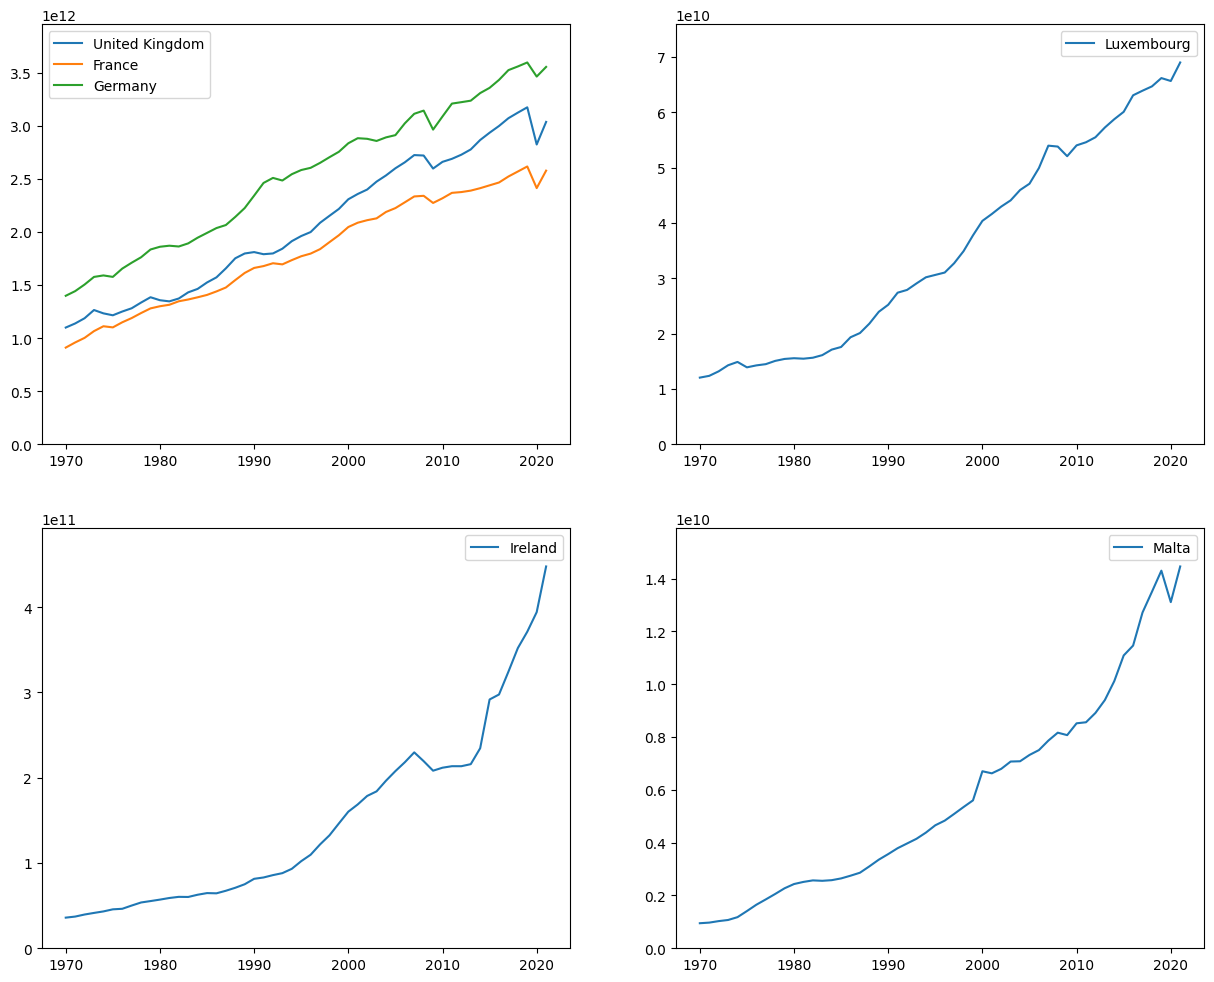

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(15, 12))

for country_plot in country_6[0:3]:
  ax[0, 0].plot(df.loc[df["country"] == country_plot, "year"], df.loc[df["country"] == country_plot, "gdp"], label = country_plot)

ax[0, 1].plot(df.loc[df["country"] == "Luxembourg", "year"], df.loc[df["country"] == "Luxembourg", "gdp"], label = "Luxembourg" )
ax[1, 0].plot(df.loc[df["country"] == "Ireland", "year"], df.loc[df["country"] == "Ireland", "gdp"], label = "Ireland" )
ax[1, 1].plot(df.loc[df["country"] == "Malta", "year"], df.loc[df["country"] == "Malta", "gdp"], label = "Malta" )

ax[0, 0].set_ylim((0,df.loc[df["country"].isin(country_6[0:3]), "gdp"].max()*1.1))
ax[0, 1].set_ylim((0,df.loc[df["country"]== "Luxembourg", "gdp"].max()*1.1))
ax[1, 0].set_ylim((0,df.loc[df["country"]== "Ireland", "gdp"].max()*1.1))
ax[1, 1].set_ylim((0,df.loc[df["country"]== "Malta", "gdp"].max()*1.1))

ax[0, 0].legend()
ax[0, 1].legend()
ax[1, 0].legend()
ax[1, 1].legend()

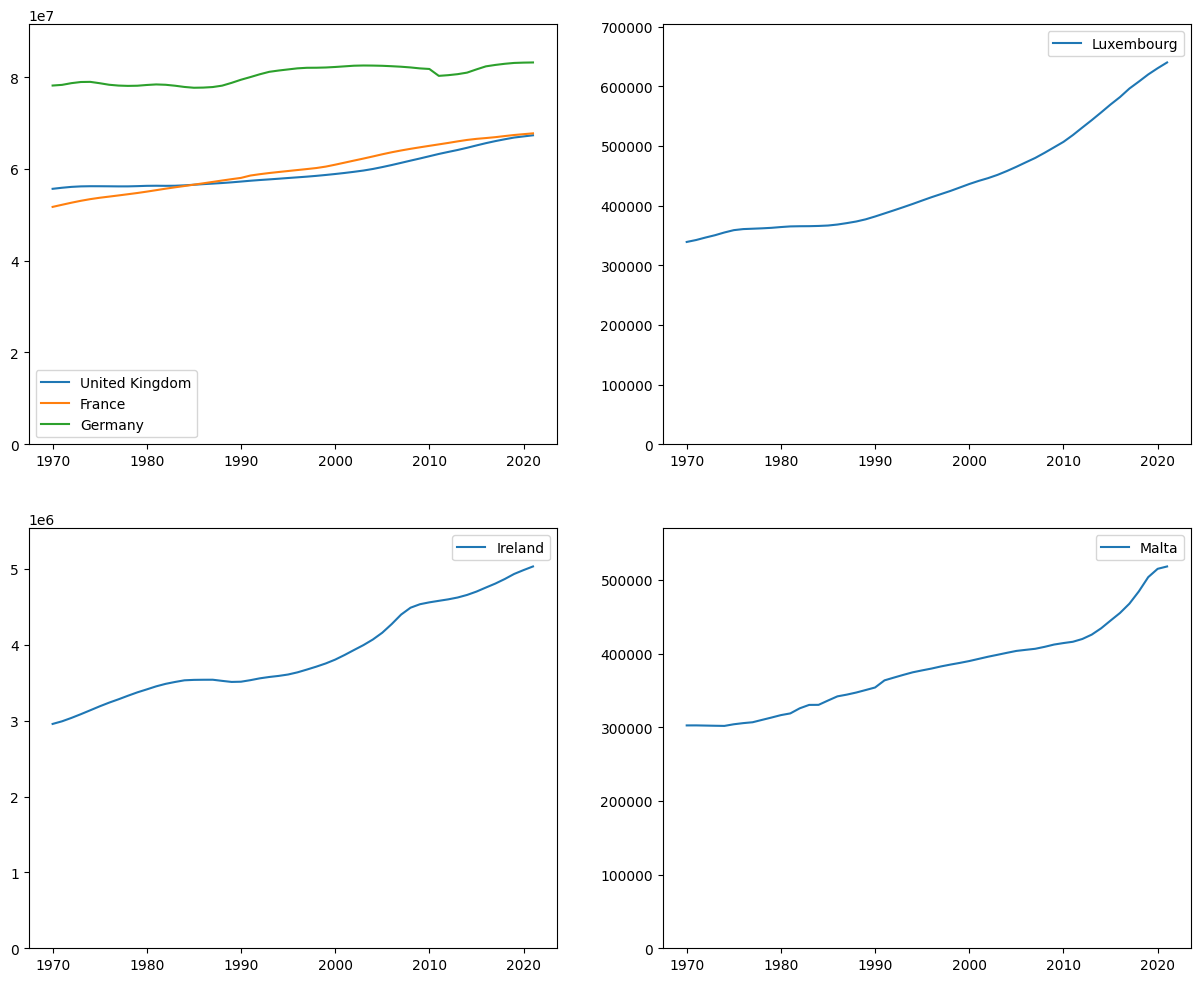

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(15, 12))

for country_plot in country_6[0:3]:
  ax[0, 0].plot(df.loc[df["country"] == country_plot, "year"], df.loc[df["country"] == country_plot, "pop"], label = country_plot)

ax[0, 1].plot(df.loc[df["country"] == "Luxembourg", "year"], df.loc[df["country"] == "Luxembourg", "pop"], label = "Luxembourg" )
ax[1, 0].plot(df.loc[df["country"] == "Ireland", "year"], df.loc[df["country"] == "Ireland", "pop"], label = "Ireland" )
ax[1, 1].plot(df.loc[df["country"] == "Malta", "year"], df.loc[df["country"] == "Malta", "pop"], label = "Malta" )

ax[0, 0].set_ylim((0,df.loc[df["country"].isin(country_6[0:3]), "pop"].max()*1.1))
ax[0, 1].set_ylim((0,df.loc[df["country"]== "Luxembourg", "pop"].max()*1.1))
ax[1, 0].set_ylim((0,df.loc[df["country"]== "Ireland", "pop"].max()*1.1))
ax[1, 1].set_ylim((0,df.loc[df["country"]== "Malta", "pop"].max()*1.1))

ax[0, 0].legend()
ax[0, 1].legend()
ax[1, 0].legend()
ax[1, 1].legend()